In [149]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

#from pandasql import sqldf

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import catboost as cb

import datetime

In [150]:
#show max 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [151]:
# turn off warnings 
import warnings
warnings.filterwarnings("ignore")

In [152]:
raw_data = pd.read_csv('newyork_housing.csv')

In [153]:
raw_data.shape

(75630, 1507)

# Functions

In [154]:
def detect_outlier(df, col):
    Q1= df[col].quantile(0.25)
    Q3= df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_index = df.index[ (df[col] < lower_bound) | (df[col] > upper_bound)]
    lower_outliers_index = df.index[ (df[col] < lower_bound)]
    upper_outliers_index = df.index[ (df[col] > upper_bound)]
    
    return outliers_index, lower_outliers_index, upper_outliers_index

In [155]:
def remove_outlier(df , ls):
    ls = sorted(set(ls))
    clean_df= df.drop(ls)
    
    return clean_df

In [110]:
df['price'].quantile(0.25)

485000.0

# Data Prep

In [90]:
#for c,i in enumerate(raw_data.columns):
    #print(c,i)

In [156]:
# getting rid of columns that contain photos
raw_data = raw_data[raw_data.columns.drop(list(raw_data.filter(regex='photos')))]

# getting rid of columns that priceHistory
raw_data = raw_data[raw_data.columns.drop(list(raw_data.filter(regex='priceHistory')))]

# getting rid of columns >> accessibilityFeatures : It's all NULL 
raw_data = raw_data[raw_data.columns.drop(list(raw_data.filter(regex='accessibilityFeatures')))]


# drop NULL values for on market date : we need to know which ones have a date 
raw_data = raw_data.dropna(subset = ['resoFactsStats/onMarketDate'])

# Only keep sold or recently sold properties 
raw_data = raw_data[(raw_data['homeStatus'] == 'SOLD') | (raw_data['homeStatus'] == 'RECENTLY_SOLD')]

#To clean lot size and unify units: replace comma, extract only numbers from col
raw_data['resoFactsStats/lotSize']= raw_data['resoFactsStats/lotSize'].str.replace(',','')
#split by space
raw_data[['lotsize','unit']] = raw_data["resoFactsStats/lotSize"].str.split(" ", 1, expand=True)
#convert string to float
raw_data['lotsize']=raw_data['lotsize'].astype(float)
# convert acre to sqft
raw_data['lot_size_sqf'] = raw_data['lotsize'].apply(lambda x: x * 43560 if x < 100 else x)


#replace comma, extract only numbers from col , and replace Nan with 0 for hoa
raw_data['resoFactsStats/associationFee']= raw_data['resoFactsStats/associationFee'].str.replace(',','')
raw_data['resoFactsStats/associationFee']= raw_data['resoFactsStats/associationFee'].str.extract('(\d+)')
raw_data['hoa']=raw_data['resoFactsStats/associationFee'].fillna(0)


# Convert the weird data format and only keep properties after 2020-05 based on their distribution plot
raw_data['y-m'] =raw_data['resoFactsStats/onMarketDate'].apply(lambda d: datetime.datetime.fromtimestamp(int(d)/1000).strftime('%Y-%m'))
#raw_data['y-m'].value_counts().sort_index(ascending = True).plot()#raw_data['y-m'].value_counts().sort_index(ascending = True).plot()
#raw_data['y-m'].value_counts().sort_index(ascending = False)

#replace NaN with 0 
raw_data['resoFactsStats/hasFireplace'].fillna(0, inplace = True)

#replace NaN first with '0', then create another column that is binary and shows if a property have basement or not 
raw_data['resoFactsStats/basement'].fillna('0', inplace = True)
raw_data['basement'] = raw_data['resoFactsStats/basement'].apply(lambda x: 0 if x == 'None' or x== '0' else 1)


# convert to rigth data types
raw_data=raw_data.astype({'hoa': 'float'})
raw_data=raw_data.astype({'resoFactsStats/hasFireplace': 'float'})

## Extracting timefarme with the highest ferquency
df= raw_data[raw_data['y-m']>='2020-05']



In [158]:
want_cols= ['bathrooms', 
            'bedrooms', 
            'yearBuilt', 
            'propertyTaxRate',
            'livingArea',
            'lot_size_sqf',
            'schools/0/rating',
            'hoa',
            'resoFactsStats/garageSpaces',
            'resoFactsStats/hasFireplace',
            'basement',
            'latitude',
            'longitude',
            'price'
            ]

df = df[want_cols]
df.rename({
            #'resoFactsStats/hasGarage' : 'hasGarage', garage spaces have the same impact, maybe even better
            'resoFactsStats/garageSpaces' : 'garageSpaces',
            'resoFactsStats/hasFireplace' : 'hasFireplace',
            'propertyTaxRate' : 'propTax',
            'schools/0/rating': 'schlRnk',
              }, axis=1, inplace=True)

KeyError: "['propertyTaxRate', 'schools/0/rating', 'resoFactsStats/garageSpaces', 'resoFactsStats/hasFireplace'] not in index"

In [111]:
df.shape

(7219, 14)

In [159]:
df.dtypes

bathrooms       float64
bedrooms        float64
yearBuilt       float64
propTax         float64
livingArea      float64
lot_size_sqf    float64
schlRnk         float64
hoa             float64
garageSpaces      int64
hasFireplace    float64
basement          int64
latitude        float64
longitude       float64
price           float64
dtype: object

In [189]:
clean_df.garageSpaces.value_counts()

0       3131
1       2950
2        539
3         44
4         38
5          8
200        2
6          1
400        1
120        1
1422       1
Name: garageSpaces, dtype: int64

# Remove outliers

<AxesSubplot:xlabel='price', ylabel='Count'>

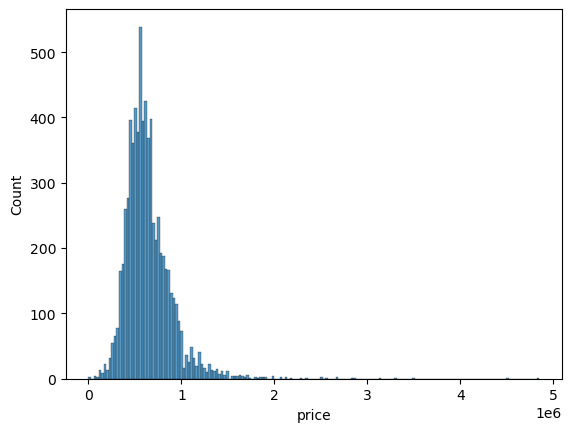

In [72]:
# right skewed 
#sn.histplot(df['price'])

In [118]:
df['price'].describe()

count    7.219000e+03
mean     6.439512e+05
std      2.613737e+05
min      1.000000e+01
25%      4.850000e+05
50%      6.000000e+05
75%      7.500000e+05
max      4.850000e+06
Name: price, dtype: float64

In [121]:
df[df['price']== df['price'].min()]

bathrooms  bedrooms  yearBuilt  propTax  livingArea  lot_size_sqf  \
26727        2.0       3.0     1965.0     0.87      1600.0        2800.0   

       schlRnk  hoa  garageSpaces  hasFireplace  basement   latitude  \
26727      9.0  0.0             1           0.0         1  40.569698   

       longitude  price  
26727 -74.130478   10.0

<AxesSubplot:xlabel='price'>

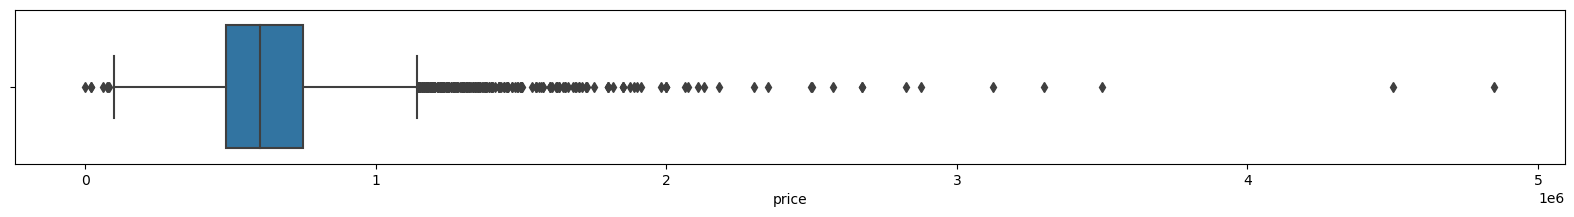

In [108]:
#fig, ax =plt.subplots(figsize=(20,2))
#sn.boxplot(x = df['price'] )

In [160]:
# take out price outliers
outliers_index, lower_index, upper_index = detect_outlier(df, 'price')

In [129]:
lower_index.tolist()

[517, 3381, 21133, 21135, 26727, 31367, 40602]

In [161]:
#remove lower bound
clean_df= remove_outlier(df, lower_index.tolist())
# remove prices over 2M
clean_df = clean_df[clean_df['price'] <= 2000000]

<AxesSubplot:xlabel='price', ylabel='Count'>

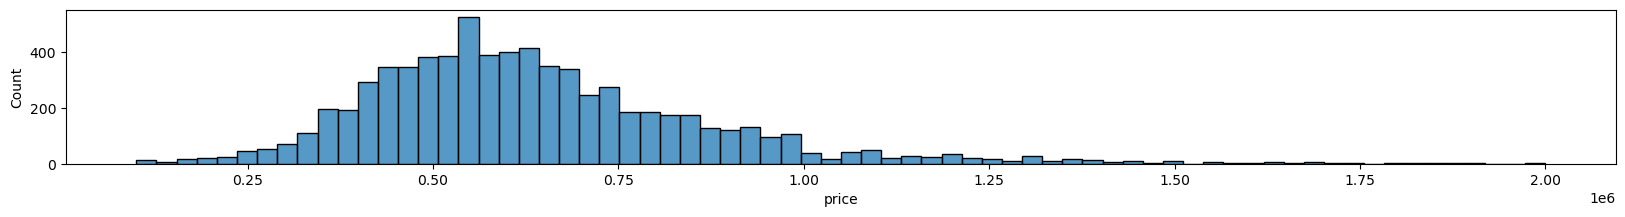

In [162]:
fig, ax =plt.subplots(figsize=(20,2))
sn.histplot(x = clean_df['price'] )

In [190]:
#remove outlier
clean_df = clean_df[clean_df['garageSpaces'] <= 6]

In [138]:
clean_df['lot_size_sqf'].describe()

count    7.001000e+03
mean     4.221829e+03
std      1.525119e+04
min      1.600000e+02
25%      2.178000e+03
50%      3.050000e+03
75%      4.397000e+03
max      1.027145e+06
Name: lot_size_sqf, dtype: float64

<AxesSubplot:xlabel='lot_size_sqf', ylabel='Count'>

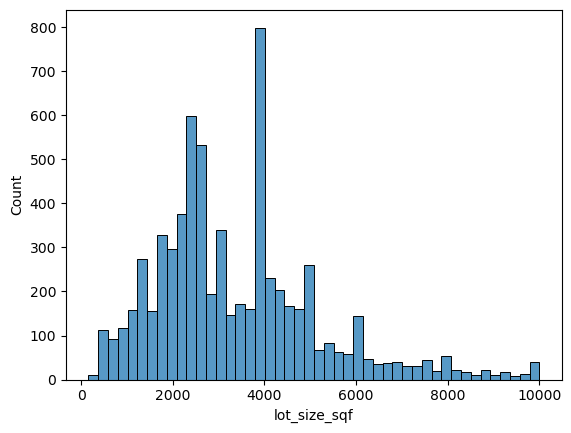

In [166]:
# right skewed 
sn.histplot(clean_df[clean_df['lot_size_sqf']<10000].lot_size_sqf)

In [167]:
clean_df[clean_df['lot_size_sqf']<=10000].shape

(6799, 14)

In [163]:
#take out lot_sie_sqf outlier out
clean_df=clean_df[clean_df['lot_size_sqf']<=10000]

<AxesSubplot:xlabel='latitude', ylabel='Count'>

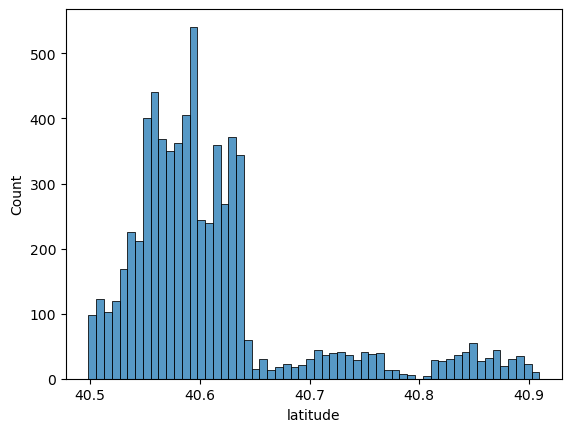

In [168]:
# right skewed
sn.histplot(clean_df['latitude'])

<AxesSubplot:xlabel='longitude', ylabel='Count'>

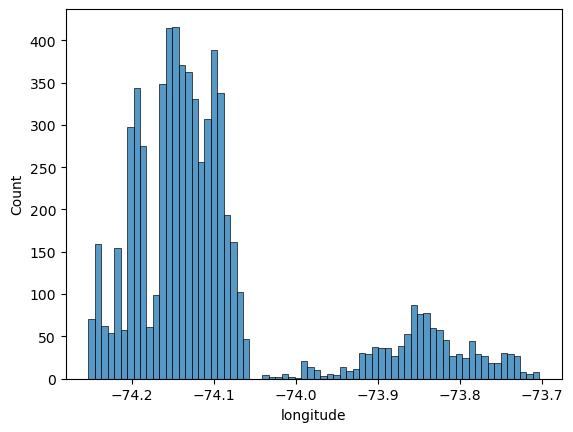

In [169]:
# right skewed
sn.histplot(clean_df['longitude'])

<AxesSubplot:xlabel='bathrooms', ylabel='Count'>

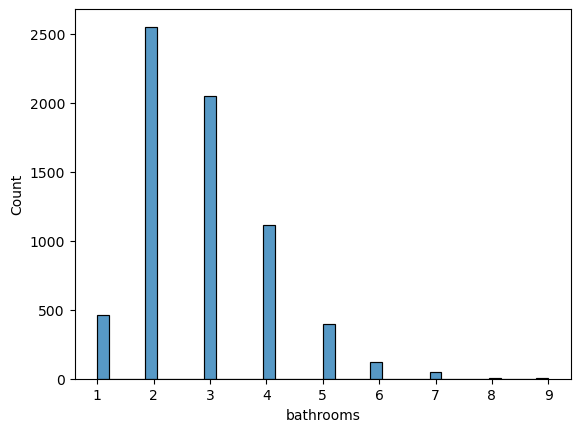

In [170]:
# right skewed
sn.histplot(clean_df['bathrooms'])

<AxesSubplot:xlabel='bedrooms', ylabel='Count'>

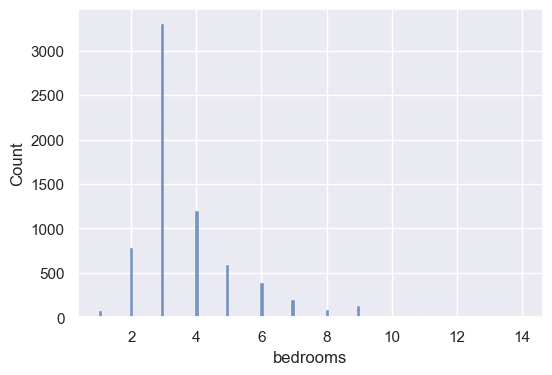

In [176]:
# right skewed
sn.set(rc={"figure.figsize":(6, 4)})
sn.histplot(clean_df['bedrooms'])

In [177]:
#take out outlier
clean_df=clean_df[clean_df['bedrooms']<10]

In [193]:
import matplotlib.pyplot as plt
# Define the number of rows and columns you want
sn.set(rc={"figure.figsize":(16, 20)})
#plt.figure(figsize=(10,20))
n_rows=17
n_cols=1
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

for i, column in enumerate(clean_df.columns):
    sn.histplot(df[column],ax=axes[i])

Error in callback <function flush_figures at 0x000001EF35936940> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

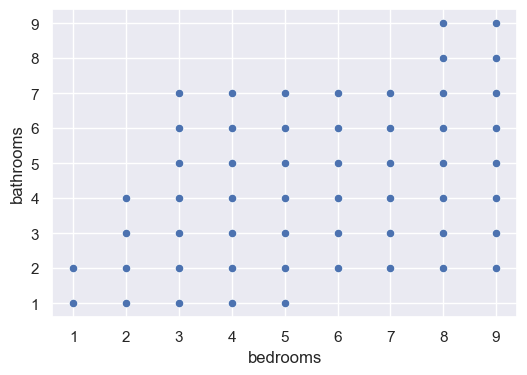

In [178]:
sn.scatterplot(x= 'basement_',
                    y="bathrooms",
                    data= clean_df)

<AxesSubplot:xlabel='yearBuilt', ylabel='Count'>

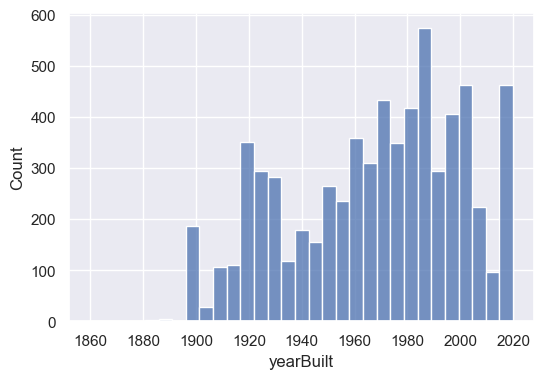

In [197]:
# meh
sn.set(rc={"figure.figsize":(6, 4)})
sn.histplot(clean_df['yearBuilt'])

<AxesSubplot:xlabel='propTax', ylabel='Count'>

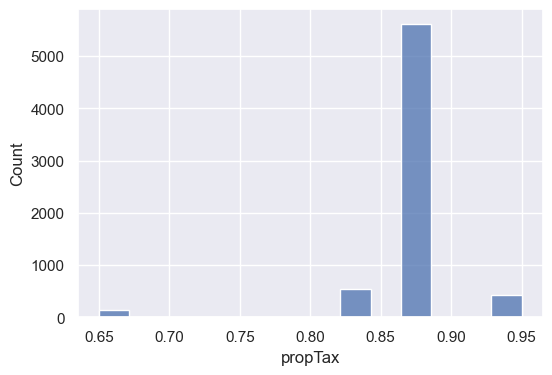

In [198]:
# meh
sn.histplot(clean_df['propTax'])

<AxesSubplot:xlabel='schlRnk', ylabel='Count'>

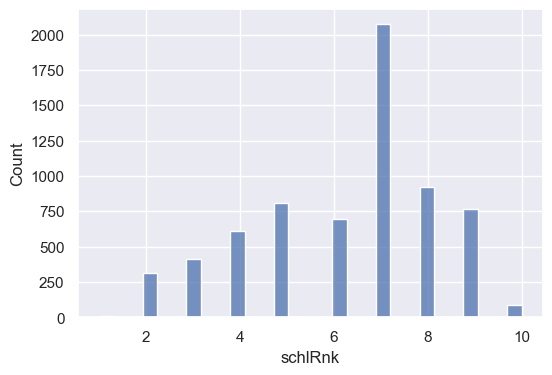

In [181]:
# good
sn.histplot(clean_df['schlRnk'])

In [184]:
clean_df['hoa'].max()

6100.0

<AxesSubplot:xlabel='hoa', ylabel='Count'>

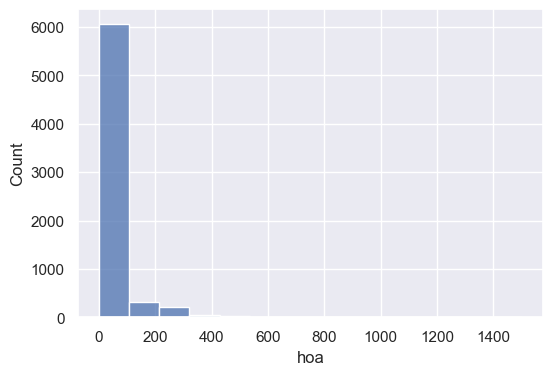

In [186]:
# right skewed >> better to keep under 1000 or 2000; or give them the max of hoa we want to keep: so we don't drop too much
sn.histplot(clean_df['hoa'])

<AxesSubplot:xlabel='garageSpaces', ylabel='Count'>

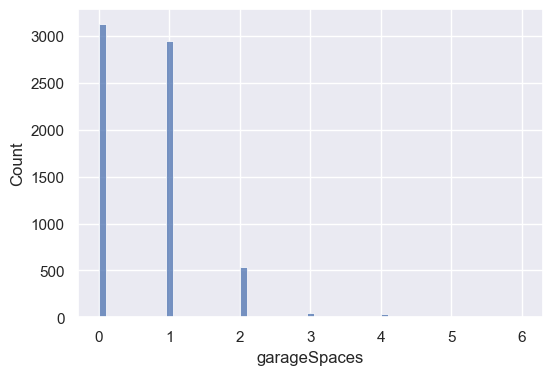

In [191]:
# right skewed
sn.histplot(clean_df['garageSpaces'])

<AxesSubplot:xlabel='hasFireplace', ylabel='Count'>

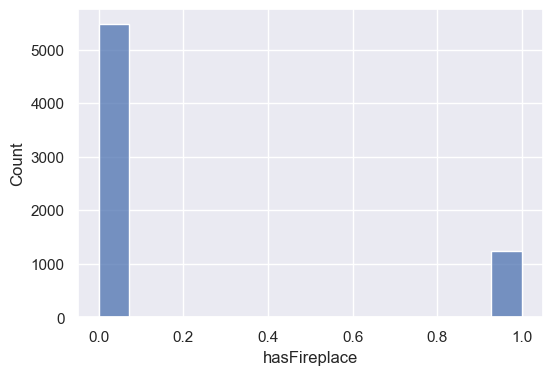

In [192]:
# right skewed
sn.histplot(clean_df['hasFireplace'])

<AxesSubplot:xlabel='basement', ylabel='Count'>

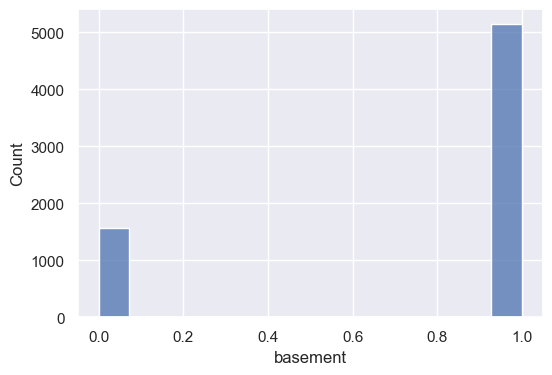

In [199]:
# good
sn.histplot(clean_df['basement'])

In [42]:
''' # list of columns that need to remove outliers

col_list = ['price', 'latitude', 'longitude', 'lotSize', 'bedrooms', 'bathrooms','hoa', 'garageSpaces' ]

# create a list to store outputs from all the columns 

outlier_index_list = []

for i in col_list:
    outliers_index, lower_outliers_index, upper_outliers_index = detect_outlier(df, i)
    outlier_index_list.extend(upper_outliers_index)
    
df_cleaned = remove_outlier(df , outlier_index_list)'''

In [43]:
df.shape, df_cleaned.shape

((7138, 17), (5052, 17))

<AxesSubplot:xlabel='price', ylabel='Count'>

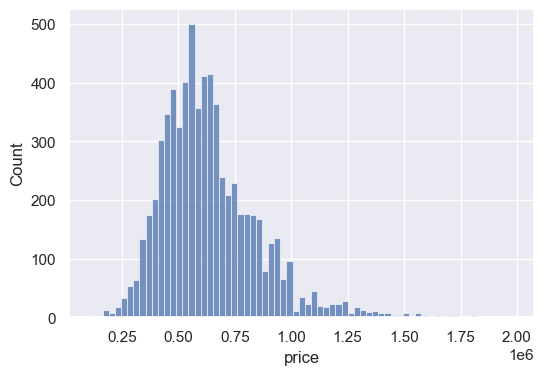

In [202]:
# more normal now
sn.histplot(clean_df['price'])

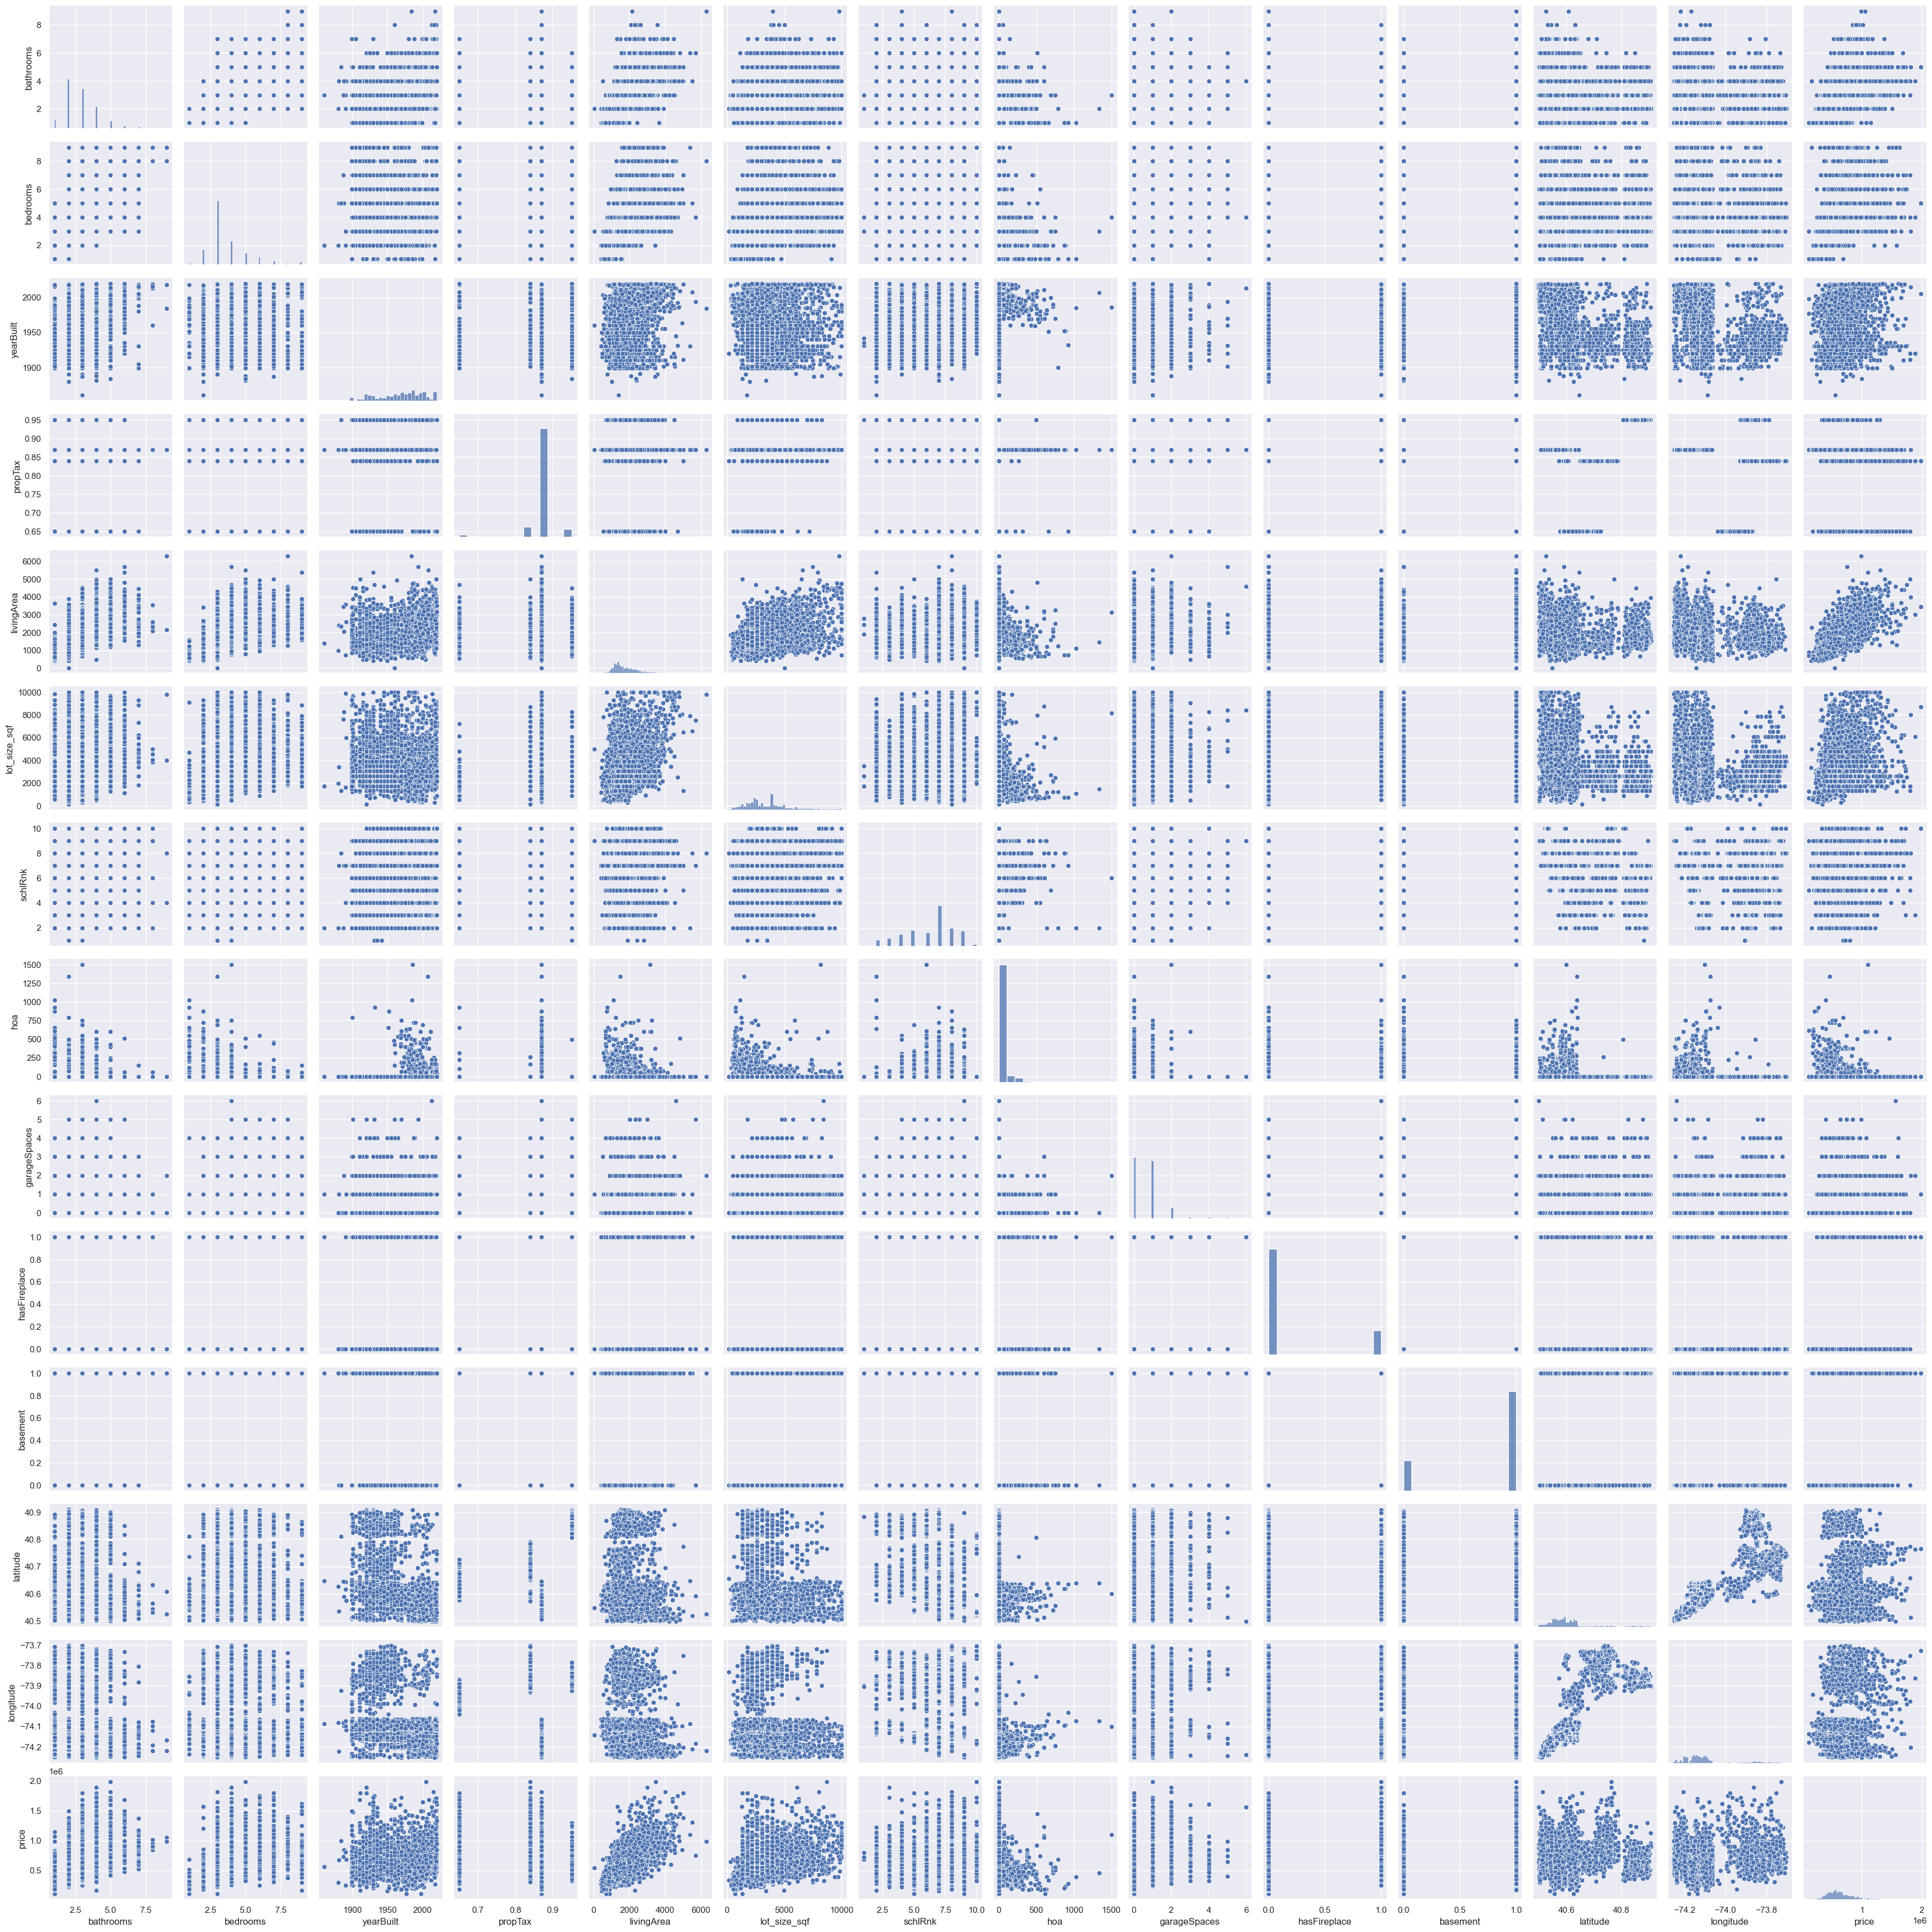

In [200]:
sn.pairplot(clean_df)

<AxesSubplot:xlabel='livingArea', ylabel='price'>

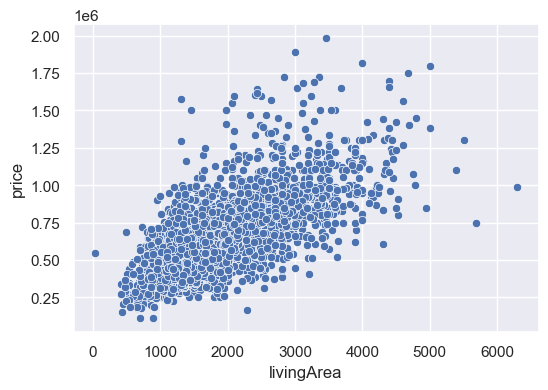

In [203]:
sn.scatterplot(x= 'livingArea',
                    y="price",
                    data= clean_df)

In [ ]:
## Question: Should I leave the ouliers here? They don't seem to be problematic >> NO THEY ARE!!!!

In [204]:
clean_df.shape

(6711, 14)

In [207]:
for i in clean_df.columns:
    print(i,' NULL %= ', (clean_df[i].isnull().sum() * 100) / 6711)

bathrooms  NULL %=  0.05960363582178513
bedrooms  NULL %=  0.0
yearBuilt  NULL %=  0.10430636268812397
propTax  NULL %=  0.014900908955446282
livingArea  NULL %=  5.304723588138876
lot_size_sqf  NULL %=  0.0
schlRnk  NULL %=  0.32781999701981823
hoa  NULL %=  0.0
garageSpaces  NULL %=  0.0
hasFireplace  NULL %=  0.0
basement  NULL %=  0.0
latitude  NULL %=  0.0
longitude  NULL %=  0.0
price  NULL %=  0.0


In [55]:
# usign sql syntax with pandas
pysqldf = lambda q: sqldf(q, globals())

In [78]:
query = '''SELECT * 
            FROM df 
            where garageSpaces <100 
            limit 2'''
pysqldf(query)

city  zipcode  bathrooms  bedrooms  yearBuilt                type  \
0          Bronx  10471.0        5.0       4.0     1925.0         Residential   
1  Broad Channel  11693.0        2.0       3.0     1935.0  Residential Income   

  condition  livingArea      y-m  hasVeiw  hasGarage  garageSpaces  \
0      None      3596.0  2020-07        0          0             0   
1      None         NaN  2020-09        0          0             0   

   hasFireplace                            basement     homeStatus   latitude  \
0           1.0  Partially Finished,Walk-Out Access  RECENTLY_SOLD  40.900173   
1           NaN                                None  RECENTLY_SOLD  40.605995   

   longitude      price   age  
0 -73.910187  2075000.0  97.0  
1 -73.819237   560000.0  87.0

In [208]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6711 entries, 520 to 75623
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bathrooms     6707 non-null   float64
 1   bedrooms      6711 non-null   float64
 2   yearBuilt     6704 non-null   float64
 3   propTax       6710 non-null   float64
 4   livingArea    6355 non-null   float64
 5   lot_size_sqf  6711 non-null   float64
 6   schlRnk       6689 non-null   float64
 7   hoa           6711 non-null   float64
 8   garageSpaces  6711 non-null   int64  
 9   hasFireplace  6711 non-null   float64
 10  basement      6711 non-null   int64  
 11  latitude      6711 non-null   float64
 12  longitude     6711 non-null   float64
 13  price         6711 non-null   float64
dtypes: float64(12), int64(2)
memory usage: 1.0 MB


# X and y

In [209]:
clean_df.head()

bathrooms  bedrooms  yearBuilt  propTax  livingArea  lot_size_sqf  \
520         2.0       3.0     1935.0     0.84         NaN        2178.0   
675         4.0       6.0     2005.0     0.84         NaN        2178.0   
1436        3.0       4.0     1938.0     0.95      2090.0        4356.0   
1459        4.0       5.0     1995.0     0.95      2146.0        3049.2   
1481        2.0       4.0     1960.0     0.95      2256.0        4356.0   

      schlRnk  hoa  garageSpaces  hasFireplace  basement   latitude  \
520       7.0  0.0             0           0.0         0  40.605995   
675       6.0  0.0             0           0.0         0  40.608162   
1436      5.0  0.0             0           0.0         0  40.891418   
1459      4.0  0.0             1           0.0         0  40.883373   
1481      7.0  0.0             4           0.0         1  40.889427   

      longitude     price  
520  -73.819237  560000.0  
675  -73.755051  660000.0  
1436 -73.831688  695000.0  
1459 -73.837082  749000.0  
1481 -73.816902  610000.0

In [212]:
X= clean_df.iloc[:,:-1]

In [211]:
X.head()

bathrooms  bedrooms  yearBuilt  propTax  livingArea  lot_size_sqf  \
142        5.0       4.0     1925.0     0.95      3596.0           NaN   
513        1.0       NaN     1940.0     0.84       800.0        6969.6   
517        NaN       NaN        NaN     0.84         NaN        4356.0   
518        NaN       NaN        NaN     0.84         NaN        2178.0   
520        2.0       3.0     1935.0     0.84         NaN        2178.0   

     schlRnk  hoa  garageSpaces  hasFireplace  basement   latitude  longitude  
142      7.0  0.0             0           1.0         1  40.900173 -73.910187  
513      7.0  0.0             0           0.0         0  40.604259 -73.818222  
517      7.0  0.0             0           0.0         0  40.604092 -73.817932  
518      8.0  0.0             0           0.0         0  40.652229 -73.828850  
520      7.0  0.0             0           0.0         0  40.605995 -73.819237

In [213]:
y = clean_df['price']

In [214]:
y.shape, X.shape

((6711,), (6711, 13))

In [44]:
#yc= df_cleaned['price']
#Xc= df_cleaned.loc[:, df_cleaned.columns != 'price']

In [45]:
#yc.shape , Xc.shape

((5052,), (5052, 16))

## Model

In [215]:
# model without outliers:
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size = 0.2, random_state=5)


In [216]:
X_test, X_valid, y_test, y_valid = train_test_split(X_remain, y_remain, test_size = 0.5, random_state=5)

In [217]:
model_c = cb.CatBoostRegressor(loss_function='RMSE') #try R2 as well

In [218]:
model_c.fit(X_train, y_train, plot= True, eval_set=(X_valid, y_valid), verbose = False )
#epochs maybe 200

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [219]:
cv_16_results = cross_val_score(model_c, X_train, y_train, cv=16, verbose= False)

Learning rate set to 0.052851
0:	learn: 210740.0625995	total: 2.33ms	remaining: 2.33s
1:	learn: 204273.2982204	total: 4.62ms	remaining: 2.31s
2:	learn: 198210.1854473	total: 6.72ms	remaining: 2.23s
3:	learn: 192755.5096212	total: 8.77ms	remaining: 2.18s
4:	learn: 187545.4045692	total: 10.7ms	remaining: 2.13s
5:	learn: 182726.9574848	total: 12.9ms	remaining: 2.14s
6:	learn: 178258.1014888	total: 15.2ms	remaining: 2.15s
7:	learn: 174241.6889460	total: 17.2ms	remaining: 2.13s
8:	learn: 170303.0375186	total: 19.3ms	remaining: 2.12s
9:	learn: 166597.3375476	total: 21.6ms	remaining: 2.13s
10:	learn: 162874.2411660	total: 23.8ms	remaining: 2.14s
11:	learn: 159218.3380825	total: 25.6ms	remaining: 2.11s
12:	learn: 156015.7851537	total: 27.9ms	remaining: 2.12s
13:	learn: 152867.8186658	total: 30.1ms	remaining: 2.12s
14:	learn: 150006.4285282	total: 32.4ms	remaining: 2.13s
15:	learn: 147154.7770787	total: 34.5ms	remaining: 2.12s
16:	learn: 144626.8162833	total: 36.7ms	remaining: 2.12s
17:	learn: 

190:	learn: 80018.7393028	total: 392ms	remaining: 1.66s
191:	learn: 79932.9342623	total: 395ms	remaining: 1.66s
192:	learn: 79851.7451873	total: 396ms	remaining: 1.66s
193:	learn: 79748.5021542	total: 398ms	remaining: 1.65s
194:	learn: 79667.6543556	total: 400ms	remaining: 1.65s
195:	learn: 79626.8126060	total: 402ms	remaining: 1.65s
196:	learn: 79526.5986341	total: 404ms	remaining: 1.65s
197:	learn: 79429.8832262	total: 406ms	remaining: 1.64s
198:	learn: 79375.4184280	total: 407ms	remaining: 1.64s
199:	learn: 79279.4601579	total: 409ms	remaining: 1.64s
200:	learn: 79187.5071368	total: 411ms	remaining: 1.63s
201:	learn: 79109.7456320	total: 413ms	remaining: 1.63s
202:	learn: 79035.4862921	total: 415ms	remaining: 1.63s
203:	learn: 78964.1099272	total: 417ms	remaining: 1.63s
204:	learn: 78894.5167967	total: 419ms	remaining: 1.62s
205:	learn: 78799.6745216	total: 421ms	remaining: 1.62s
206:	learn: 78694.2965626	total: 423ms	remaining: 1.62s
207:	learn: 78616.2062822	total: 425ms	remaining

395:	learn: 68366.9677296	total: 778ms	remaining: 1.19s
396:	learn: 68319.3971125	total: 780ms	remaining: 1.18s
397:	learn: 68286.7864397	total: 782ms	remaining: 1.18s
398:	learn: 68236.0098317	total: 784ms	remaining: 1.18s
399:	learn: 68217.6186594	total: 785ms	remaining: 1.18s
400:	learn: 68186.3832227	total: 787ms	remaining: 1.18s
401:	learn: 68153.3168652	total: 789ms	remaining: 1.17s
402:	learn: 68132.3564892	total: 791ms	remaining: 1.17s
403:	learn: 68096.1859700	total: 793ms	remaining: 1.17s
404:	learn: 68057.5400315	total: 795ms	remaining: 1.17s
405:	learn: 68023.3954028	total: 796ms	remaining: 1.17s
406:	learn: 67983.2233714	total: 798ms	remaining: 1.16s
407:	learn: 67940.0637270	total: 800ms	remaining: 1.16s
408:	learn: 67914.7740945	total: 802ms	remaining: 1.16s
409:	learn: 67880.4673255	total: 804ms	remaining: 1.16s
410:	learn: 67842.8598163	total: 806ms	remaining: 1.16s
411:	learn: 67788.1840696	total: 808ms	remaining: 1.15s
412:	learn: 67738.5595356	total: 810ms	remaining

571:	learn: 62677.8714416	total: 1.17s	remaining: 873ms
572:	learn: 62649.0223546	total: 1.17s	remaining: 871ms
573:	learn: 62624.8842637	total: 1.17s	remaining: 869ms
574:	learn: 62597.2402439	total: 1.17s	remaining: 867ms
575:	learn: 62576.8994015	total: 1.18s	remaining: 865ms
576:	learn: 62572.4969637	total: 1.18s	remaining: 863ms
577:	learn: 62550.2740017	total: 1.18s	remaining: 861ms
578:	learn: 62538.9851213	total: 1.18s	remaining: 859ms
579:	learn: 62513.4809977	total: 1.18s	remaining: 857ms
580:	learn: 62472.6932897	total: 1.18s	remaining: 855ms
581:	learn: 62423.6022440	total: 1.19s	remaining: 853ms
582:	learn: 62387.1356316	total: 1.19s	remaining: 851ms
583:	learn: 62342.5549965	total: 1.19s	remaining: 850ms
584:	learn: 62307.2893994	total: 1.19s	remaining: 848ms
585:	learn: 62273.4669785	total: 1.2s	remaining: 846ms
586:	learn: 62260.7503009	total: 1.2s	remaining: 844ms
587:	learn: 62231.5998363	total: 1.2s	remaining: 842ms
588:	learn: 62228.1600476	total: 1.2s	remaining: 83

779:	learn: 57507.7833258	total: 1.55s	remaining: 438ms
780:	learn: 57482.8338924	total: 1.55s	remaining: 436ms
781:	learn: 57458.3833297	total: 1.56s	remaining: 434ms
782:	learn: 57432.5725547	total: 1.56s	remaining: 432ms
783:	learn: 57419.7432483	total: 1.56s	remaining: 430ms
784:	learn: 57409.7087865	total: 1.56s	remaining: 428ms
785:	learn: 57400.2617260	total: 1.56s	remaining: 426ms
786:	learn: 57366.5071158	total: 1.56s	remaining: 424ms
787:	learn: 57332.4295416	total: 1.57s	remaining: 422ms
788:	learn: 57306.3721694	total: 1.57s	remaining: 420ms
789:	learn: 57303.1257086	total: 1.57s	remaining: 418ms
790:	learn: 57280.0221614	total: 1.57s	remaining: 416ms
791:	learn: 57260.0639716	total: 1.57s	remaining: 414ms
792:	learn: 57225.5457446	total: 1.58s	remaining: 412ms
793:	learn: 57202.5118652	total: 1.58s	remaining: 410ms
794:	learn: 57186.1339571	total: 1.58s	remaining: 408ms
795:	learn: 57152.3609990	total: 1.58s	remaining: 406ms
796:	learn: 57117.4562307	total: 1.58s	remaining

989:	learn: 53216.0584904	total: 1.94s	remaining: 19.6ms
990:	learn: 53207.0566343	total: 1.95s	remaining: 17.7ms
991:	learn: 53203.3646644	total: 1.95s	remaining: 15.7ms
992:	learn: 53180.7669968	total: 1.95s	remaining: 13.7ms
993:	learn: 53165.1181483	total: 1.95s	remaining: 11.8ms
994:	learn: 53143.6217693	total: 1.95s	remaining: 9.82ms
995:	learn: 53130.5167809	total: 1.96s	remaining: 7.86ms
996:	learn: 53105.7857984	total: 1.96s	remaining: 5.89ms
997:	learn: 53079.2065889	total: 1.96s	remaining: 3.93ms
998:	learn: 53057.1169105	total: 1.96s	remaining: 1.96ms
999:	learn: 53046.9602327	total: 1.96s	remaining: 0us
Learning rate set to 0.052851
0:	learn: 208627.7823527	total: 2.07ms	remaining: 2.06s
1:	learn: 202246.7066015	total: 4.01ms	remaining: 2s
2:	learn: 196409.6051284	total: 5.99ms	remaining: 1.99s
3:	learn: 190931.4465493	total: 7.83ms	remaining: 1.95s
4:	learn: 185767.0655103	total: 9.66ms	remaining: 1.92s
5:	learn: 181008.4129568	total: 11.4ms	remaining: 1.89s
6:	learn: 176

170:	learn: 80801.8299287	total: 317ms	remaining: 1.54s
171:	learn: 80733.0656669	total: 319ms	remaining: 1.54s
172:	learn: 80641.6095587	total: 322ms	remaining: 1.54s
173:	learn: 80539.8729793	total: 324ms	remaining: 1.53s
174:	learn: 80463.7444826	total: 326ms	remaining: 1.53s
175:	learn: 80358.1483008	total: 327ms	remaining: 1.53s
176:	learn: 80293.1878639	total: 329ms	remaining: 1.53s
177:	learn: 80188.5400262	total: 331ms	remaining: 1.53s
178:	learn: 80088.9671207	total: 333ms	remaining: 1.53s
179:	learn: 79965.7964695	total: 335ms	remaining: 1.52s
180:	learn: 79886.5920560	total: 337ms	remaining: 1.52s
181:	learn: 79769.1222633	total: 339ms	remaining: 1.52s
182:	learn: 79646.4675744	total: 341ms	remaining: 1.52s
183:	learn: 79538.0354845	total: 343ms	remaining: 1.52s
184:	learn: 79456.7937304	total: 345ms	remaining: 1.52s
185:	learn: 79375.4603597	total: 347ms	remaining: 1.52s
186:	learn: 79293.3732755	total: 349ms	remaining: 1.51s
187:	learn: 79209.2915135	total: 350ms	remaining

393:	learn: 67754.3921100	total: 722ms	remaining: 1.11s
394:	learn: 67712.5712350	total: 724ms	remaining: 1.11s
395:	learn: 67650.1660878	total: 726ms	remaining: 1.11s
396:	learn: 67610.4034973	total: 727ms	remaining: 1.1s
397:	learn: 67596.3534763	total: 729ms	remaining: 1.1s
398:	learn: 67554.2933245	total: 731ms	remaining: 1.1s
399:	learn: 67510.9414645	total: 733ms	remaining: 1.1s
400:	learn: 67468.0620950	total: 735ms	remaining: 1.1s
401:	learn: 67426.4483299	total: 737ms	remaining: 1.1s
402:	learn: 67383.3725270	total: 739ms	remaining: 1.09s
403:	learn: 67357.7762650	total: 741ms	remaining: 1.09s
404:	learn: 67332.9076478	total: 743ms	remaining: 1.09s
405:	learn: 67309.9854056	total: 745ms	remaining: 1.09s
406:	learn: 67275.8960294	total: 747ms	remaining: 1.09s
407:	learn: 67238.8447760	total: 749ms	remaining: 1.09s
408:	learn: 67183.6509747	total: 751ms	remaining: 1.08s
409:	learn: 67152.5187770	total: 753ms	remaining: 1.08s
410:	learn: 67095.2443513	total: 754ms	remaining: 1.08

561:	learn: 61866.8864310	total: 1.11s	remaining: 862ms
562:	learn: 61849.3974292	total: 1.11s	remaining: 861ms
563:	learn: 61824.3953236	total: 1.11s	remaining: 859ms
564:	learn: 61799.9030350	total: 1.11s	remaining: 857ms
565:	learn: 61781.9304041	total: 1.11s	remaining: 855ms
566:	learn: 61757.3742942	total: 1.12s	remaining: 853ms
567:	learn: 61705.7198250	total: 1.12s	remaining: 851ms
568:	learn: 61676.5715849	total: 1.12s	remaining: 849ms
569:	learn: 61645.4418618	total: 1.12s	remaining: 847ms
570:	learn: 61616.9346934	total: 1.12s	remaining: 845ms
571:	learn: 61569.3180892	total: 1.13s	remaining: 843ms
572:	learn: 61528.7472348	total: 1.13s	remaining: 842ms
573:	learn: 61493.2283169	total: 1.13s	remaining: 840ms
574:	learn: 61482.6412835	total: 1.13s	remaining: 838ms
575:	learn: 61472.4078377	total: 1.13s	remaining: 835ms
576:	learn: 61431.3409191	total: 1.14s	remaining: 833ms
577:	learn: 61399.1803938	total: 1.14s	remaining: 831ms
578:	learn: 61385.3788244	total: 1.14s	remaining

756:	learn: 56844.9924109	total: 1.49s	remaining: 478ms
757:	learn: 56835.8059782	total: 1.49s	remaining: 477ms
758:	learn: 56789.3400134	total: 1.49s	remaining: 475ms
759:	learn: 56754.4063862	total: 1.5s	remaining: 473ms
760:	learn: 56733.5430315	total: 1.5s	remaining: 471ms
761:	learn: 56711.5091503	total: 1.5s	remaining: 469ms
762:	learn: 56692.2003780	total: 1.5s	remaining: 467ms
763:	learn: 56671.0991132	total: 1.5s	remaining: 465ms
764:	learn: 56646.1595105	total: 1.51s	remaining: 463ms
765:	learn: 56613.5307325	total: 1.51s	remaining: 461ms
766:	learn: 56595.8278515	total: 1.51s	remaining: 459ms
767:	learn: 56565.6671033	total: 1.51s	remaining: 457ms
768:	learn: 56541.2623157	total: 1.51s	remaining: 455ms
769:	learn: 56523.7404617	total: 1.52s	remaining: 453ms
770:	learn: 56510.6672666	total: 1.52s	remaining: 452ms
771:	learn: 56491.3090835	total: 1.52s	remaining: 450ms
772:	learn: 56465.9812528	total: 1.52s	remaining: 448ms
773:	learn: 56439.6494858	total: 1.53s	remaining: 446

959:	learn: 52736.1466240	total: 1.88s	remaining: 78.3ms
960:	learn: 52713.2898555	total: 1.88s	remaining: 76.4ms
961:	learn: 52688.6330703	total: 1.88s	remaining: 74.4ms
962:	learn: 52680.8532705	total: 1.89s	remaining: 72.5ms
963:	learn: 52667.8950950	total: 1.89s	remaining: 70.5ms
964:	learn: 52649.4541822	total: 1.89s	remaining: 68.5ms
965:	learn: 52634.6582179	total: 1.89s	remaining: 66.6ms
966:	learn: 52620.9927696	total: 1.89s	remaining: 64.6ms
967:	learn: 52598.9263136	total: 1.9s	remaining: 62.7ms
968:	learn: 52590.4508351	total: 1.9s	remaining: 60.8ms
969:	learn: 52569.1928530	total: 1.9s	remaining: 58.8ms
970:	learn: 52554.6404446	total: 1.9s	remaining: 56.9ms
971:	learn: 52515.2948950	total: 1.91s	remaining: 54.9ms
972:	learn: 52497.4135377	total: 1.91s	remaining: 53ms
973:	learn: 52478.9952240	total: 1.91s	remaining: 51ms
974:	learn: 52461.8256804	total: 1.91s	remaining: 49ms
975:	learn: 52444.2464823	total: 1.91s	remaining: 47.1ms
976:	learn: 52414.3738171	total: 1.92s	re

139:	learn: 84255.2506765	total: 263ms	remaining: 1.61s
140:	learn: 84190.5911237	total: 265ms	remaining: 1.61s
141:	learn: 84081.0041715	total: 269ms	remaining: 1.63s
142:	learn: 83995.8483524	total: 273ms	remaining: 1.63s
143:	learn: 83901.6315115	total: 276ms	remaining: 1.64s
144:	learn: 83761.4721777	total: 279ms	remaining: 1.65s
145:	learn: 83637.4324542	total: 282ms	remaining: 1.65s
146:	learn: 83492.4100718	total: 285ms	remaining: 1.65s
147:	learn: 83368.6953672	total: 287ms	remaining: 1.65s
148:	learn: 83227.9780949	total: 289ms	remaining: 1.65s
149:	learn: 83110.5238516	total: 291ms	remaining: 1.65s
150:	learn: 83044.9255951	total: 294ms	remaining: 1.65s
151:	learn: 82937.4323331	total: 296ms	remaining: 1.65s
152:	learn: 82843.5361130	total: 298ms	remaining: 1.65s
153:	learn: 82762.0045833	total: 300ms	remaining: 1.65s
154:	learn: 82618.8484854	total: 302ms	remaining: 1.65s
155:	learn: 82527.4191269	total: 304ms	remaining: 1.64s
156:	learn: 82423.3375908	total: 306ms	remaining

338:	learn: 70230.0470926	total: 637ms	remaining: 1.24s
339:	learn: 70177.3464610	total: 639ms	remaining: 1.24s
340:	learn: 70121.4874217	total: 641ms	remaining: 1.24s
341:	learn: 70073.3328190	total: 643ms	remaining: 1.24s
342:	learn: 70034.8325992	total: 645ms	remaining: 1.24s
343:	learn: 70006.3644380	total: 647ms	remaining: 1.23s
344:	learn: 69978.8913167	total: 649ms	remaining: 1.23s
345:	learn: 69925.6097161	total: 651ms	remaining: 1.23s
346:	learn: 69886.7198680	total: 653ms	remaining: 1.23s
347:	learn: 69829.2724731	total: 655ms	remaining: 1.23s
348:	learn: 69771.6662112	total: 657ms	remaining: 1.23s
349:	learn: 69716.2032682	total: 659ms	remaining: 1.22s
350:	learn: 69664.7926340	total: 661ms	remaining: 1.22s
351:	learn: 69616.0640544	total: 663ms	remaining: 1.22s
352:	learn: 69572.0229964	total: 664ms	remaining: 1.22s
353:	learn: 69569.4261847	total: 666ms	remaining: 1.22s
354:	learn: 69502.8422901	total: 668ms	remaining: 1.21s
355:	learn: 69464.8383226	total: 670ms	remaining

541:	learn: 62929.1641973	total: 1.02s	remaining: 866ms
542:	learn: 62912.2521358	total: 1.03s	remaining: 864ms
543:	learn: 62892.6667224	total: 1.03s	remaining: 862ms
544:	learn: 62856.8916737	total: 1.03s	remaining: 861ms
545:	learn: 62832.5250024	total: 1.03s	remaining: 859ms
546:	learn: 62794.8509944	total: 1.03s	remaining: 858ms
547:	learn: 62772.8331631	total: 1.04s	remaining: 856ms
548:	learn: 62740.9562986	total: 1.04s	remaining: 855ms
549:	learn: 62716.7148080	total: 1.04s	remaining: 853ms
550:	learn: 62687.7940478	total: 1.04s	remaining: 851ms
551:	learn: 62661.1374561	total: 1.05s	remaining: 849ms
552:	learn: 62619.2228755	total: 1.05s	remaining: 847ms
553:	learn: 62600.4426228	total: 1.05s	remaining: 845ms
554:	learn: 62577.4284808	total: 1.05s	remaining: 843ms
555:	learn: 62545.3957339	total: 1.05s	remaining: 842ms
556:	learn: 62511.4200059	total: 1.06s	remaining: 840ms
557:	learn: 62509.5433329	total: 1.06s	remaining: 838ms
558:	learn: 62508.3851088	total: 1.06s	remaining

740:	learn: 57764.7256145	total: 1.41s	remaining: 494ms
741:	learn: 57740.9846563	total: 1.41s	remaining: 492ms
742:	learn: 57712.4953563	total: 1.42s	remaining: 490ms
743:	learn: 57701.9530211	total: 1.42s	remaining: 488ms
744:	learn: 57660.3579500	total: 1.42s	remaining: 486ms
745:	learn: 57648.4642795	total: 1.42s	remaining: 484ms
746:	learn: 57615.5450743	total: 1.42s	remaining: 482ms
747:	learn: 57579.8799926	total: 1.43s	remaining: 480ms
748:	learn: 57538.0870323	total: 1.43s	remaining: 479ms
749:	learn: 57521.2483855	total: 1.43s	remaining: 477ms
750:	learn: 57496.5256588	total: 1.43s	remaining: 475ms
751:	learn: 57495.1202292	total: 1.44s	remaining: 473ms
752:	learn: 57468.6254537	total: 1.44s	remaining: 472ms
753:	learn: 57432.2266257	total: 1.44s	remaining: 470ms
754:	learn: 57387.4294056	total: 1.44s	remaining: 468ms
755:	learn: 57361.7577406	total: 1.44s	remaining: 466ms
756:	learn: 57343.0731204	total: 1.45s	remaining: 464ms
757:	learn: 57341.9531178	total: 1.45s	remaining

941:	learn: 53526.7821799	total: 1.8s	remaining: 111ms
942:	learn: 53502.3044220	total: 1.8s	remaining: 109ms
943:	learn: 53483.0230996	total: 1.81s	remaining: 107ms
944:	learn: 53456.5844406	total: 1.81s	remaining: 105ms
945:	learn: 53431.9204437	total: 1.81s	remaining: 103ms
946:	learn: 53419.4674424	total: 1.81s	remaining: 101ms
947:	learn: 53395.0229980	total: 1.81s	remaining: 99.6ms
948:	learn: 53377.7801002	total: 1.82s	remaining: 97.7ms
949:	learn: 53358.2521455	total: 1.82s	remaining: 95.8ms
950:	learn: 53333.8927583	total: 1.82s	remaining: 93.8ms
951:	learn: 53310.5267702	total: 1.82s	remaining: 91.9ms
952:	learn: 53298.3516272	total: 1.82s	remaining: 90ms
953:	learn: 53277.7277173	total: 1.83s	remaining: 88.1ms
954:	learn: 53263.7714000	total: 1.83s	remaining: 86.2ms
955:	learn: 53242.8659387	total: 1.83s	remaining: 84.3ms
956:	learn: 53219.3686591	total: 1.83s	remaining: 82.4ms
957:	learn: 53203.2823919	total: 1.84s	remaining: 80.5ms
958:	learn: 53184.4022742	total: 1.84s	re

116:	learn: 85186.6560327	total: 233ms	remaining: 1.76s
117:	learn: 85095.3386517	total: 235ms	remaining: 1.76s
118:	learn: 84998.4715066	total: 237ms	remaining: 1.76s
119:	learn: 84871.8431342	total: 239ms	remaining: 1.75s
120:	learn: 84769.7062316	total: 241ms	remaining: 1.75s
121:	learn: 84625.9093253	total: 243ms	remaining: 1.75s
122:	learn: 84465.8228923	total: 245ms	remaining: 1.75s
123:	learn: 84323.4425274	total: 247ms	remaining: 1.74s
124:	learn: 84247.6117616	total: 249ms	remaining: 1.74s
125:	learn: 84157.7157554	total: 251ms	remaining: 1.74s
126:	learn: 84065.4836651	total: 253ms	remaining: 1.74s
127:	learn: 83994.3811252	total: 255ms	remaining: 1.74s
128:	learn: 83880.6470670	total: 257ms	remaining: 1.73s
129:	learn: 83760.4484629	total: 259ms	remaining: 1.73s
130:	learn: 83658.5655983	total: 262ms	remaining: 1.74s
131:	learn: 83560.6968182	total: 265ms	remaining: 1.74s
132:	learn: 83430.6407426	total: 267ms	remaining: 1.74s
133:	learn: 83370.7562253	total: 269ms	remaining

316:	learn: 70601.7622242	total: 618ms	remaining: 1.33s
317:	learn: 70543.9014463	total: 620ms	remaining: 1.33s
318:	learn: 70500.1055901	total: 622ms	remaining: 1.33s
319:	learn: 70463.1131590	total: 624ms	remaining: 1.33s
320:	learn: 70443.7965963	total: 626ms	remaining: 1.32s
321:	learn: 70398.3330650	total: 628ms	remaining: 1.32s
322:	learn: 70374.2625266	total: 630ms	remaining: 1.32s
323:	learn: 70328.2714029	total: 631ms	remaining: 1.32s
324:	learn: 70278.7285892	total: 634ms	remaining: 1.31s
325:	learn: 70229.4225455	total: 636ms	remaining: 1.31s
326:	learn: 70198.0597038	total: 638ms	remaining: 1.31s
327:	learn: 70163.2378894	total: 641ms	remaining: 1.31s
328:	learn: 70087.8418862	total: 643ms	remaining: 1.31s
329:	learn: 70059.1449586	total: 645ms	remaining: 1.31s
330:	learn: 69991.6501943	total: 647ms	remaining: 1.31s
331:	learn: 69959.7193824	total: 649ms	remaining: 1.3s
332:	learn: 69919.8620013	total: 651ms	remaining: 1.3s
333:	learn: 69881.9115965	total: 653ms	remaining: 

501:	learn: 63426.2021200	total: 1s	remaining: 995ms
502:	learn: 63394.9346616	total: 1s	remaining: 994ms
503:	learn: 63359.4839299	total: 1.01s	remaining: 992ms
504:	learn: 63325.9723110	total: 1.01s	remaining: 991ms
505:	learn: 63303.4983564	total: 1.01s	remaining: 989ms
506:	learn: 63282.6998898	total: 1.01s	remaining: 987ms
507:	learn: 63259.0017710	total: 1.02s	remaining: 985ms
508:	learn: 63221.7942979	total: 1.02s	remaining: 983ms
509:	learn: 63190.4748530	total: 1.02s	remaining: 982ms
510:	learn: 63146.1089029	total: 1.02s	remaining: 980ms
511:	learn: 63100.2517000	total: 1.03s	remaining: 979ms
512:	learn: 63060.1396866	total: 1.03s	remaining: 977ms
513:	learn: 63011.1903587	total: 1.03s	remaining: 975ms
514:	learn: 62983.5845589	total: 1.03s	remaining: 973ms
515:	learn: 62950.4250188	total: 1.03s	remaining: 971ms
516:	learn: 62911.9521773	total: 1.04s	remaining: 970ms
517:	learn: 62884.5248105	total: 1.04s	remaining: 968ms
518:	learn: 62860.3566729	total: 1.04s	remaining: 966m

682:	learn: 58315.3855161	total: 1.39s	remaining: 645ms
683:	learn: 58292.9846767	total: 1.39s	remaining: 643ms
684:	learn: 58263.4698436	total: 1.39s	remaining: 641ms
685:	learn: 58241.1575592	total: 1.4s	remaining: 639ms
686:	learn: 58219.3199090	total: 1.4s	remaining: 637ms
687:	learn: 58217.5164910	total: 1.4s	remaining: 635ms
688:	learn: 58169.0768426	total: 1.4s	remaining: 633ms
689:	learn: 58140.7280133	total: 1.4s	remaining: 631ms
690:	learn: 58113.3123118	total: 1.41s	remaining: 629ms
691:	learn: 58083.3134586	total: 1.41s	remaining: 627ms
692:	learn: 58065.1106382	total: 1.41s	remaining: 625ms
693:	learn: 58043.1681427	total: 1.41s	remaining: 623ms
694:	learn: 58023.7565687	total: 1.42s	remaining: 621ms
695:	learn: 58003.3387212	total: 1.42s	remaining: 619ms
696:	learn: 57970.1286161	total: 1.42s	remaining: 617ms
697:	learn: 57935.1333777	total: 1.42s	remaining: 615ms
698:	learn: 57914.7746543	total: 1.42s	remaining: 613ms
699:	learn: 57874.4051301	total: 1.43s	remaining: 611

870:	learn: 54434.2273117	total: 1.78s	remaining: 263ms
871:	learn: 54414.8498961	total: 1.78s	remaining: 261ms
872:	learn: 54391.7945289	total: 1.78s	remaining: 259ms
873:	learn: 54377.0096259	total: 1.78s	remaining: 257ms
874:	learn: 54370.8379881	total: 1.79s	remaining: 255ms
875:	learn: 54338.2985848	total: 1.79s	remaining: 253ms
876:	learn: 54314.6937581	total: 1.79s	remaining: 251ms
877:	learn: 54304.3093706	total: 1.79s	remaining: 249ms
878:	learn: 54303.4099807	total: 1.79s	remaining: 247ms
879:	learn: 54274.0860240	total: 1.8s	remaining: 245ms
880:	learn: 54273.3583053	total: 1.8s	remaining: 243ms
881:	learn: 54245.4451208	total: 1.8s	remaining: 241ms
882:	learn: 54223.3294975	total: 1.8s	remaining: 239ms
883:	learn: 54208.9192843	total: 1.8s	remaining: 237ms
884:	learn: 54194.9408364	total: 1.81s	remaining: 235ms
885:	learn: 54175.2417846	total: 1.81s	remaining: 233ms
886:	learn: 54154.9812394	total: 1.81s	remaining: 231ms
887:	learn: 54146.0430485	total: 1.81s	remaining: 229

35:	learn: 113353.9230722	total: 73.7ms	remaining: 1.97s
36:	learn: 112413.5112618	total: 76.3ms	remaining: 1.98s
37:	learn: 111465.2473249	total: 78.5ms	remaining: 1.99s
38:	learn: 110695.0291674	total: 81ms	remaining: 2s
39:	learn: 109725.5796765	total: 82.9ms	remaining: 1.99s
40:	learn: 108965.2937977	total: 84.9ms	remaining: 1.98s
41:	learn: 108117.7098445	total: 87ms	remaining: 1.98s
42:	learn: 107239.4272733	total: 89.2ms	remaining: 1.99s
43:	learn: 106631.4815458	total: 91.3ms	remaining: 1.98s
44:	learn: 106056.8508182	total: 93.5ms	remaining: 1.98s
45:	learn: 105494.4795462	total: 95.5ms	remaining: 1.98s
46:	learn: 104841.6828871	total: 97.7ms	remaining: 1.98s
47:	learn: 104247.6061892	total: 99.7ms	remaining: 1.98s
48:	learn: 103821.7551406	total: 102ms	remaining: 1.98s
49:	learn: 103326.0420099	total: 104ms	remaining: 1.97s
50:	learn: 102697.9177942	total: 106ms	remaining: 1.97s
51:	learn: 102260.5806879	total: 108ms	remaining: 1.97s
52:	learn: 101670.0216400	total: 110ms	rem

227:	learn: 75785.2308921	total: 456ms	remaining: 1.54s
228:	learn: 75729.3141703	total: 459ms	remaining: 1.54s
229:	learn: 75721.0919538	total: 461ms	remaining: 1.54s
230:	learn: 75631.9125746	total: 463ms	remaining: 1.54s
231:	learn: 75580.7243036	total: 465ms	remaining: 1.54s
232:	learn: 75510.3987511	total: 467ms	remaining: 1.54s
233:	learn: 75441.7825368	total: 469ms	remaining: 1.53s
234:	learn: 75374.3034839	total: 471ms	remaining: 1.53s
235:	learn: 75287.8466639	total: 473ms	remaining: 1.53s
236:	learn: 75272.8370011	total: 475ms	remaining: 1.53s
237:	learn: 75193.1128318	total: 477ms	remaining: 1.53s
238:	learn: 75138.3029559	total: 479ms	remaining: 1.53s
239:	learn: 75078.3027282	total: 482ms	remaining: 1.52s
240:	learn: 74980.9108079	total: 484ms	remaining: 1.52s
241:	learn: 74889.5887051	total: 486ms	remaining: 1.52s
242:	learn: 74836.3609504	total: 488ms	remaining: 1.52s
243:	learn: 74788.4226618	total: 490ms	remaining: 1.52s
244:	learn: 74722.6078732	total: 492ms	remaining

411:	learn: 66503.6490932	total: 842ms	remaining: 1.2s
412:	learn: 66450.0579570	total: 844ms	remaining: 1.2s
413:	learn: 66440.7170760	total: 846ms	remaining: 1.2s
414:	learn: 66389.4205007	total: 849ms	remaining: 1.2s
415:	learn: 66341.3117919	total: 851ms	remaining: 1.19s
416:	learn: 66294.2395993	total: 854ms	remaining: 1.19s
417:	learn: 66252.5841726	total: 857ms	remaining: 1.19s
418:	learn: 66197.6221550	total: 860ms	remaining: 1.19s
419:	learn: 66161.6078506	total: 862ms	remaining: 1.19s
420:	learn: 66131.6234261	total: 865ms	remaining: 1.19s
421:	learn: 66094.6755539	total: 867ms	remaining: 1.19s
422:	learn: 66048.4604579	total: 870ms	remaining: 1.19s
423:	learn: 66020.4090056	total: 872ms	remaining: 1.18s
424:	learn: 65985.5902643	total: 874ms	remaining: 1.18s
425:	learn: 65965.5959500	total: 876ms	remaining: 1.18s
426:	learn: 65961.7881488	total: 878ms	remaining: 1.18s
427:	learn: 65887.0247911	total: 879ms	remaining: 1.18s
428:	learn: 65883.7682478	total: 881ms	remaining: 1.

594:	learn: 61150.8422714	total: 1.23s	remaining: 835ms
595:	learn: 61117.9126222	total: 1.23s	remaining: 833ms
596:	learn: 61094.8456621	total: 1.23s	remaining: 831ms
597:	learn: 61079.4099272	total: 1.23s	remaining: 829ms
598:	learn: 61061.5974386	total: 1.24s	remaining: 827ms
599:	learn: 61044.9424177	total: 1.24s	remaining: 825ms
600:	learn: 61007.6456176	total: 1.24s	remaining: 822ms
601:	learn: 61001.4171567	total: 1.24s	remaining: 820ms
602:	learn: 60973.4522850	total: 1.24s	remaining: 819ms
603:	learn: 60945.9314210	total: 1.25s	remaining: 817ms
604:	learn: 60897.0134443	total: 1.25s	remaining: 815ms
605:	learn: 60868.1524665	total: 1.25s	remaining: 813ms
606:	learn: 60841.5481697	total: 1.25s	remaining: 810ms
607:	learn: 60817.9807253	total: 1.25s	remaining: 809ms
608:	learn: 60797.8176478	total: 1.25s	remaining: 806ms
609:	learn: 60773.1610221	total: 1.26s	remaining: 804ms
610:	learn: 60726.9535455	total: 1.26s	remaining: 802ms
611:	learn: 60725.6112066	total: 1.26s	remaining

780:	learn: 56502.6057703	total: 1.62s	remaining: 454ms
781:	learn: 56484.6160757	total: 1.62s	remaining: 452ms
782:	learn: 56463.8715532	total: 1.62s	remaining: 450ms
783:	learn: 56436.6598634	total: 1.63s	remaining: 448ms
784:	learn: 56410.9129647	total: 1.63s	remaining: 446ms
785:	learn: 56386.1891713	total: 1.63s	remaining: 444ms
786:	learn: 56360.2469275	total: 1.63s	remaining: 442ms
787:	learn: 56332.1189485	total: 1.63s	remaining: 439ms
788:	learn: 56306.6092471	total: 1.64s	remaining: 437ms
789:	learn: 56298.3997250	total: 1.64s	remaining: 435ms
790:	learn: 56273.4403830	total: 1.64s	remaining: 433ms
791:	learn: 56248.3870709	total: 1.64s	remaining: 431ms
792:	learn: 56221.8932127	total: 1.64s	remaining: 429ms
793:	learn: 56190.5942026	total: 1.65s	remaining: 427ms
794:	learn: 56186.6789824	total: 1.65s	remaining: 425ms
795:	learn: 56169.0556263	total: 1.65s	remaining: 423ms
796:	learn: 56146.1319434	total: 1.65s	remaining: 421ms
797:	learn: 56126.5372152	total: 1.65s	remaining

967:	learn: 52904.5124820	total: 2.01s	remaining: 66.4ms
968:	learn: 52884.6354883	total: 2.01s	remaining: 64.3ms
969:	learn: 52868.9491764	total: 2.01s	remaining: 62.2ms
970:	learn: 52860.4524436	total: 2.01s	remaining: 60.1ms
971:	learn: 52832.3463085	total: 2.02s	remaining: 58.1ms
972:	learn: 52806.7569856	total: 2.02s	remaining: 56ms
973:	learn: 52784.8324819	total: 2.02s	remaining: 53.9ms
974:	learn: 52751.0961434	total: 2.02s	remaining: 51.8ms
975:	learn: 52726.2468050	total: 2.02s	remaining: 49.8ms
976:	learn: 52723.4881097	total: 2.02s	remaining: 47.7ms
977:	learn: 52693.8980412	total: 2.03s	remaining: 45.6ms
978:	learn: 52686.3193760	total: 2.03s	remaining: 43.5ms
979:	learn: 52666.1487656	total: 2.03s	remaining: 41.5ms
980:	learn: 52658.5711597	total: 2.03s	remaining: 39.4ms
981:	learn: 52644.9963769	total: 2.04s	remaining: 37.3ms
982:	learn: 52623.4646089	total: 2.04s	remaining: 35.2ms
983:	learn: 52622.2356252	total: 2.04s	remaining: 33.2ms
984:	learn: 52600.1892343	total: 

129:	learn: 84876.3693669	total: 273ms	remaining: 1.82s
130:	learn: 84765.6602591	total: 275ms	remaining: 1.82s
131:	learn: 84672.8355682	total: 277ms	remaining: 1.82s
132:	learn: 84555.8647795	total: 280ms	remaining: 1.82s
133:	learn: 84503.8489598	total: 282ms	remaining: 1.82s
134:	learn: 84402.1956186	total: 284ms	remaining: 1.82s
135:	learn: 84284.9109423	total: 286ms	remaining: 1.82s
136:	learn: 84198.7357753	total: 288ms	remaining: 1.82s
137:	learn: 84148.0390386	total: 291ms	remaining: 1.81s
138:	learn: 84075.7927284	total: 293ms	remaining: 1.81s
139:	learn: 83930.6333162	total: 314ms	remaining: 1.93s
140:	learn: 83808.5071480	total: 317ms	remaining: 1.93s
141:	learn: 83715.6416896	total: 319ms	remaining: 1.93s
142:	learn: 83587.5268841	total: 321ms	remaining: 1.93s
143:	learn: 83507.6626731	total: 324ms	remaining: 1.93s
144:	learn: 83411.9797995	total: 327ms	remaining: 1.93s
145:	learn: 83335.8170396	total: 329ms	remaining: 1.93s
146:	learn: 83263.4581510	total: 332ms	remaining

309:	learn: 71701.7103069	total: 659ms	remaining: 1.47s
310:	learn: 71648.1300548	total: 661ms	remaining: 1.47s
311:	learn: 71560.0564353	total: 663ms	remaining: 1.46s
312:	learn: 71507.8010242	total: 665ms	remaining: 1.46s
313:	learn: 71461.8317345	total: 667ms	remaining: 1.46s
314:	learn: 71413.6939771	total: 669ms	remaining: 1.45s
315:	learn: 71339.8031816	total: 670ms	remaining: 1.45s
316:	learn: 71287.2661980	total: 672ms	remaining: 1.45s
317:	learn: 71231.9712440	total: 674ms	remaining: 1.45s
318:	learn: 71203.9557465	total: 676ms	remaining: 1.44s
319:	learn: 71157.9197735	total: 678ms	remaining: 1.44s
320:	learn: 71075.9882293	total: 680ms	remaining: 1.44s
321:	learn: 71005.8839094	total: 682ms	remaining: 1.44s
322:	learn: 70937.3872454	total: 684ms	remaining: 1.43s
323:	learn: 70883.6799186	total: 686ms	remaining: 1.43s
324:	learn: 70825.4429464	total: 688ms	remaining: 1.43s
325:	learn: 70771.4188632	total: 690ms	remaining: 1.43s
326:	learn: 70711.3896155	total: 692ms	remaining

499:	learn: 63505.3466897	total: 1.05s	remaining: 1.05s
500:	learn: 63477.0613206	total: 1.05s	remaining: 1.04s
501:	learn: 63445.7936043	total: 1.05s	remaining: 1.04s
502:	learn: 63419.4370052	total: 1.05s	remaining: 1.04s
503:	learn: 63388.7447174	total: 1.05s	remaining: 1.04s
504:	learn: 63353.8939843	total: 1.06s	remaining: 1.04s
505:	learn: 63327.1653972	total: 1.06s	remaining: 1.03s
506:	learn: 63298.2418401	total: 1.06s	remaining: 1.03s
507:	learn: 63268.6076000	total: 1.06s	remaining: 1.03s
508:	learn: 63245.2543107	total: 1.07s	remaining: 1.03s
509:	learn: 63211.8913013	total: 1.07s	remaining: 1.03s
510:	learn: 63173.6024354	total: 1.07s	remaining: 1.02s
511:	learn: 63140.5394819	total: 1.07s	remaining: 1.02s
512:	learn: 63122.2919059	total: 1.07s	remaining: 1.02s
513:	learn: 63085.2682864	total: 1.08s	remaining: 1.02s
514:	learn: 63056.1075184	total: 1.08s	remaining: 1.01s
515:	learn: 63029.3055022	total: 1.08s	remaining: 1.01s
516:	learn: 62995.8434718	total: 1.08s	remaining

691:	learn: 58221.8657646	total: 1.44s	remaining: 639ms
692:	learn: 58199.0735639	total: 1.44s	remaining: 637ms
693:	learn: 58190.3859717	total: 1.44s	remaining: 635ms
694:	learn: 58160.6235868	total: 1.44s	remaining: 633ms
695:	learn: 58129.7464678	total: 1.44s	remaining: 630ms
696:	learn: 58101.9964306	total: 1.45s	remaining: 628ms
697:	learn: 58072.6972041	total: 1.45s	remaining: 626ms
698:	learn: 58030.9652241	total: 1.45s	remaining: 624ms
699:	learn: 58000.7014835	total: 1.45s	remaining: 622ms
700:	learn: 57977.2357310	total: 1.45s	remaining: 620ms
701:	learn: 57947.2599610	total: 1.45s	remaining: 618ms
702:	learn: 57926.8855423	total: 1.46s	remaining: 616ms
703:	learn: 57902.4602232	total: 1.46s	remaining: 613ms
704:	learn: 57858.3200895	total: 1.46s	remaining: 611ms
705:	learn: 57819.8468030	total: 1.46s	remaining: 609ms
706:	learn: 57787.8806554	total: 1.47s	remaining: 607ms
707:	learn: 57767.9247753	total: 1.47s	remaining: 605ms
708:	learn: 57739.4871667	total: 1.47s	remaining

892:	learn: 53645.4645832	total: 1.82s	remaining: 218ms
893:	learn: 53604.4740474	total: 1.82s	remaining: 216ms
894:	learn: 53578.7675285	total: 1.82s	remaining: 214ms
895:	learn: 53564.7111409	total: 1.83s	remaining: 212ms
896:	learn: 53548.0188674	total: 1.83s	remaining: 210ms
897:	learn: 53529.2553253	total: 1.83s	remaining: 208ms
898:	learn: 53507.7445213	total: 1.83s	remaining: 206ms
899:	learn: 53488.0648665	total: 1.83s	remaining: 204ms
900:	learn: 53479.7939770	total: 1.84s	remaining: 202ms
901:	learn: 53465.7631288	total: 1.84s	remaining: 200ms
902:	learn: 53449.4343139	total: 1.84s	remaining: 198ms
903:	learn: 53431.3019713	total: 1.84s	remaining: 196ms
904:	learn: 53411.6731011	total: 1.84s	remaining: 194ms
905:	learn: 53390.3620222	total: 1.85s	remaining: 192ms
906:	learn: 53383.3551230	total: 1.85s	remaining: 190ms
907:	learn: 53372.2245329	total: 1.85s	remaining: 188ms
908:	learn: 53352.6273159	total: 1.85s	remaining: 186ms
909:	learn: 53340.3276266	total: 1.85s	remaining

63:	learn: 97923.8466988	total: 130ms	remaining: 1.9s
64:	learn: 97675.3664418	total: 132ms	remaining: 1.9s
65:	learn: 97372.0668368	total: 134ms	remaining: 1.89s
66:	learn: 96999.6916817	total: 136ms	remaining: 1.89s
67:	learn: 96495.2685681	total: 138ms	remaining: 1.89s
68:	learn: 96100.1436502	total: 140ms	remaining: 1.89s
69:	learn: 95684.6312279	total: 142ms	remaining: 1.89s
70:	learn: 95273.7026649	total: 144ms	remaining: 1.89s
71:	learn: 95039.3675056	total: 147ms	remaining: 1.89s
72:	learn: 94665.8704043	total: 149ms	remaining: 1.89s
73:	learn: 94368.5619092	total: 151ms	remaining: 1.89s
74:	learn: 94126.3752818	total: 153ms	remaining: 1.89s
75:	learn: 93783.2752581	total: 155ms	remaining: 1.89s
76:	learn: 93437.5360983	total: 157ms	remaining: 1.89s
77:	learn: 93167.4004400	total: 159ms	remaining: 1.88s
78:	learn: 92924.8522474	total: 161ms	remaining: 1.88s
79:	learn: 92634.1781432	total: 164ms	remaining: 1.88s
80:	learn: 92378.0241631	total: 166ms	remaining: 1.88s
81:	learn: 9

269:	learn: 73775.6616463	total: 520ms	remaining: 1.41s
270:	learn: 73732.8018025	total: 522ms	remaining: 1.41s
271:	learn: 73673.3474392	total: 524ms	remaining: 1.4s
272:	learn: 73626.3265706	total: 526ms	remaining: 1.4s
273:	learn: 73569.1861993	total: 528ms	remaining: 1.4s
274:	learn: 73485.4322971	total: 530ms	remaining: 1.4s
275:	learn: 73428.8659485	total: 532ms	remaining: 1.4s
276:	learn: 73369.5696496	total: 534ms	remaining: 1.39s
277:	learn: 73313.8988832	total: 536ms	remaining: 1.39s
278:	learn: 73265.2181907	total: 538ms	remaining: 1.39s
279:	learn: 73193.6986843	total: 540ms	remaining: 1.39s
280:	learn: 73134.4966097	total: 542ms	remaining: 1.39s
281:	learn: 73084.1597519	total: 544ms	remaining: 1.38s
282:	learn: 73057.6415559	total: 546ms	remaining: 1.38s
283:	learn: 73048.4212144	total: 548ms	remaining: 1.38s
284:	learn: 72976.3281989	total: 550ms	remaining: 1.38s
285:	learn: 72917.1925506	total: 551ms	remaining: 1.38s
286:	learn: 72900.7304754	total: 553ms	remaining: 1.3

475:	learn: 64706.6509217	total: 907ms	remaining: 998ms
476:	learn: 64654.5248188	total: 909ms	remaining: 997ms
477:	learn: 64617.1103472	total: 911ms	remaining: 995ms
478:	learn: 64613.9873442	total: 913ms	remaining: 993ms
479:	learn: 64573.7319587	total: 915ms	remaining: 991ms
480:	learn: 64539.6942290	total: 917ms	remaining: 989ms
481:	learn: 64504.4336818	total: 919ms	remaining: 987ms
482:	learn: 64455.8343749	total: 921ms	remaining: 986ms
483:	learn: 64428.1169752	total: 923ms	remaining: 984ms
484:	learn: 64384.0402195	total: 925ms	remaining: 982ms
485:	learn: 64370.5647691	total: 927ms	remaining: 981ms
486:	learn: 64339.7160859	total: 929ms	remaining: 979ms
487:	learn: 64311.3911384	total: 931ms	remaining: 977ms
488:	learn: 64287.2835647	total: 934ms	remaining: 976ms
489:	learn: 64283.4993792	total: 935ms	remaining: 973ms
490:	learn: 64249.2951496	total: 937ms	remaining: 971ms
491:	learn: 64215.0009870	total: 939ms	remaining: 969ms
492:	learn: 64185.6681777	total: 941ms	remaining

673:	learn: 59500.2847545	total: 1.3s	remaining: 627ms
674:	learn: 59459.2724763	total: 1.3s	remaining: 625ms
675:	learn: 59430.8244277	total: 1.3s	remaining: 623ms
676:	learn: 59387.8550107	total: 1.3s	remaining: 622ms
677:	learn: 59371.0201743	total: 1.3s	remaining: 620ms
678:	learn: 59344.0916617	total: 1.31s	remaining: 618ms
679:	learn: 59323.6493386	total: 1.31s	remaining: 616ms
680:	learn: 59303.5978606	total: 1.31s	remaining: 614ms
681:	learn: 59282.7324881	total: 1.31s	remaining: 612ms
682:	learn: 59259.9483358	total: 1.31s	remaining: 610ms
683:	learn: 59228.3531473	total: 1.32s	remaining: 608ms
684:	learn: 59192.9955860	total: 1.32s	remaining: 606ms
685:	learn: 59183.8724568	total: 1.32s	remaining: 605ms
686:	learn: 59138.9107977	total: 1.32s	remaining: 603ms
687:	learn: 59137.9590108	total: 1.32s	remaining: 601ms
688:	learn: 59109.0191305	total: 1.33s	remaining: 599ms
689:	learn: 59078.9061512	total: 1.33s	remaining: 597ms
690:	learn: 59077.9822657	total: 1.33s	remaining: 595

883:	learn: 55515.0576185	total: 1.69s	remaining: 221ms
884:	learn: 55496.2654605	total: 1.69s	remaining: 219ms
885:	learn: 55487.5843580	total: 1.69s	remaining: 218ms
886:	learn: 55476.2103713	total: 1.69s	remaining: 216ms
887:	learn: 55461.7098855	total: 1.69s	remaining: 214ms
888:	learn: 55438.5610737	total: 1.7s	remaining: 212ms
889:	learn: 55414.4912429	total: 1.7s	remaining: 210ms
890:	learn: 55387.3352405	total: 1.7s	remaining: 208ms
891:	learn: 55363.9149932	total: 1.7s	remaining: 206ms
892:	learn: 55353.0571697	total: 1.7s	remaining: 204ms
893:	learn: 55321.4092851	total: 1.71s	remaining: 202ms
894:	learn: 55314.0359477	total: 1.71s	remaining: 200ms
895:	learn: 55298.0869456	total: 1.71s	remaining: 199ms
896:	learn: 55275.2724590	total: 1.71s	remaining: 197ms
897:	learn: 55248.9705388	total: 1.71s	remaining: 195ms
898:	learn: 55248.2117753	total: 1.72s	remaining: 193ms
899:	learn: 55232.9395684	total: 1.72s	remaining: 191ms
900:	learn: 55217.9636724	total: 1.72s	remaining: 189

58:	learn: 99629.6030998	total: 124ms	remaining: 1.98s
59:	learn: 99249.3270425	total: 126ms	remaining: 1.98s
60:	learn: 98818.1326637	total: 128ms	remaining: 1.97s
61:	learn: 98403.6026170	total: 130ms	remaining: 1.97s
62:	learn: 98018.3714839	total: 132ms	remaining: 1.96s
63:	learn: 97634.7862488	total: 134ms	remaining: 1.96s
64:	learn: 97384.8367287	total: 136ms	remaining: 1.96s
65:	learn: 97058.6406882	total: 138ms	remaining: 1.96s
66:	learn: 96736.7350695	total: 140ms	remaining: 1.96s
67:	learn: 96284.5394217	total: 143ms	remaining: 1.95s
68:	learn: 95893.6659131	total: 145ms	remaining: 1.95s
69:	learn: 95497.1844938	total: 147ms	remaining: 1.95s
70:	learn: 95147.2083117	total: 148ms	remaining: 1.94s
71:	learn: 94918.9726818	total: 150ms	remaining: 1.94s
72:	learn: 94694.7464006	total: 152ms	remaining: 1.93s
73:	learn: 94297.6417738	total: 154ms	remaining: 1.93s
74:	learn: 94011.1230733	total: 156ms	remaining: 1.93s
75:	learn: 93697.8367427	total: 158ms	remaining: 1.92s
76:	learn:

263:	learn: 73961.5935643	total: 512ms	remaining: 1.43s
264:	learn: 73923.3472928	total: 514ms	remaining: 1.43s
265:	learn: 73879.5989564	total: 516ms	remaining: 1.42s
266:	learn: 73819.5680217	total: 518ms	remaining: 1.42s
267:	learn: 73769.7274137	total: 520ms	remaining: 1.42s
268:	learn: 73741.7087422	total: 522ms	remaining: 1.42s
269:	learn: 73701.7411159	total: 524ms	remaining: 1.42s
270:	learn: 73654.0176536	total: 525ms	remaining: 1.41s
271:	learn: 73610.4910975	total: 528ms	remaining: 1.41s
272:	learn: 73541.1483094	total: 529ms	remaining: 1.41s
273:	learn: 73500.6597238	total: 531ms	remaining: 1.41s
274:	learn: 73458.3743215	total: 533ms	remaining: 1.41s
275:	learn: 73390.3928240	total: 535ms	remaining: 1.4s
276:	learn: 73337.6156567	total: 537ms	remaining: 1.4s
277:	learn: 73303.1955600	total: 539ms	remaining: 1.4s
278:	learn: 73273.1512150	total: 541ms	remaining: 1.4s
279:	learn: 73221.1456528	total: 543ms	remaining: 1.4s
280:	learn: 73164.7272479	total: 545ms	remaining: 1.3

466:	learn: 65746.1250305	total: 899ms	remaining: 1.03s
467:	learn: 65707.8537854	total: 901ms	remaining: 1.02s
468:	learn: 65680.8064275	total: 903ms	remaining: 1.02s
469:	learn: 65638.5882124	total: 906ms	remaining: 1.02s
470:	learn: 65602.3673956	total: 908ms	remaining: 1.02s
471:	learn: 65544.7447664	total: 911ms	remaining: 1.02s
472:	learn: 65511.0512930	total: 913ms	remaining: 1.02s
473:	learn: 65487.3804029	total: 916ms	remaining: 1.02s
474:	learn: 65457.9318767	total: 918ms	remaining: 1.01s
475:	learn: 65455.4969476	total: 920ms	remaining: 1.01s
476:	learn: 65426.0722198	total: 922ms	remaining: 1.01s
477:	learn: 65393.4578183	total: 924ms	remaining: 1.01s
478:	learn: 65360.6616233	total: 926ms	remaining: 1.01s
479:	learn: 65316.2715660	total: 929ms	remaining: 1.01s
480:	learn: 65288.5474380	total: 931ms	remaining: 1s
481:	learn: 65247.9246150	total: 933ms	remaining: 1s
482:	learn: 65201.1831930	total: 935ms	remaining: 1s
483:	learn: 65155.5336187	total: 937ms	remaining: 999ms
4

659:	learn: 60207.5663052	total: 1.29s	remaining: 664ms
660:	learn: 60193.3905229	total: 1.29s	remaining: 662ms
661:	learn: 60173.9310257	total: 1.29s	remaining: 660ms
662:	learn: 60150.0635603	total: 1.29s	remaining: 658ms
663:	learn: 60119.4659973	total: 1.3s	remaining: 656ms
664:	learn: 60092.8264776	total: 1.3s	remaining: 654ms
665:	learn: 60066.6931756	total: 1.3s	remaining: 652ms
666:	learn: 60051.1816824	total: 1.3s	remaining: 651ms
667:	learn: 60042.8204738	total: 1.3s	remaining: 649ms
668:	learn: 60028.4750131	total: 1.31s	remaining: 647ms
669:	learn: 59990.2353090	total: 1.31s	remaining: 645ms
670:	learn: 59979.9812165	total: 1.31s	remaining: 643ms
671:	learn: 59945.7436707	total: 1.31s	remaining: 641ms
672:	learn: 59921.1034743	total: 1.31s	remaining: 639ms
673:	learn: 59897.1994678	total: 1.32s	remaining: 638ms
674:	learn: 59846.6253748	total: 1.32s	remaining: 636ms
675:	learn: 59821.9996866	total: 1.32s	remaining: 634ms
676:	learn: 59798.0936935	total: 1.32s	remaining: 632

843:	learn: 56156.4497164	total: 1.68s	remaining: 310ms
844:	learn: 56154.9964468	total: 1.68s	remaining: 308ms
845:	learn: 56131.7479126	total: 1.68s	remaining: 306ms
846:	learn: 56110.1982075	total: 1.68s	remaining: 304ms
847:	learn: 56084.4909844	total: 1.68s	remaining: 302ms
848:	learn: 56069.8715717	total: 1.69s	remaining: 300ms
849:	learn: 56057.1570667	total: 1.69s	remaining: 298ms
850:	learn: 56054.7741804	total: 1.69s	remaining: 296ms
851:	learn: 56039.1910212	total: 1.69s	remaining: 294ms
852:	learn: 56025.2411789	total: 1.69s	remaining: 292ms
853:	learn: 56015.9540714	total: 1.7s	remaining: 290ms
854:	learn: 56015.1402753	total: 1.7s	remaining: 288ms
855:	learn: 55991.5926544	total: 1.7s	remaining: 286ms
856:	learn: 55982.3885088	total: 1.7s	remaining: 284ms
857:	learn: 55969.3270373	total: 1.7s	remaining: 282ms
858:	learn: 55947.1463663	total: 1.71s	remaining: 280ms
859:	learn: 55913.8545047	total: 1.71s	remaining: 278ms
860:	learn: 55892.9389048	total: 1.71s	remaining: 276

20:	learn: 134927.9842573	total: 44.6ms	remaining: 2.08s
21:	learn: 132896.8539929	total: 46.7ms	remaining: 2.08s
22:	learn: 130985.2442291	total: 48.9ms	remaining: 2.08s
23:	learn: 129404.0751882	total: 50.9ms	remaining: 2.07s
24:	learn: 128008.3354321	total: 53ms	remaining: 2.07s
25:	learn: 126402.5266828	total: 54.9ms	remaining: 2.06s
26:	learn: 125010.9347027	total: 57ms	remaining: 2.06s
27:	learn: 123809.2560483	total: 59.1ms	remaining: 2.05s
28:	learn: 122493.3427728	total: 61.1ms	remaining: 2.05s
29:	learn: 121287.8486025	total: 63.1ms	remaining: 2.04s
30:	learn: 119975.3875219	total: 65.1ms	remaining: 2.04s
31:	learn: 118779.7198284	total: 67.5ms	remaining: 2.04s
32:	learn: 117557.1634291	total: 69.6ms	remaining: 2.04s
33:	learn: 116534.3417931	total: 71.5ms	remaining: 2.03s
34:	learn: 115443.4340353	total: 73.3ms	remaining: 2.02s
35:	learn: 114524.2709852	total: 75.5ms	remaining: 2.02s
36:	learn: 113510.1871274	total: 77.7ms	remaining: 2.02s
37:	learn: 112637.3305529	total: 80

229:	learn: 76529.0233210	total: 443ms	remaining: 1.48s
230:	learn: 76404.9846392	total: 445ms	remaining: 1.48s
231:	learn: 76290.6588795	total: 447ms	remaining: 1.48s
232:	learn: 76174.5414290	total: 449ms	remaining: 1.48s
233:	learn: 76101.6444691	total: 451ms	remaining: 1.48s
234:	learn: 76025.4575767	total: 453ms	remaining: 1.47s
235:	learn: 75963.2862779	total: 455ms	remaining: 1.47s
236:	learn: 75895.1094037	total: 457ms	remaining: 1.47s
237:	learn: 75821.5631706	total: 459ms	remaining: 1.47s
238:	learn: 75752.7494631	total: 461ms	remaining: 1.47s
239:	learn: 75701.0516858	total: 462ms	remaining: 1.46s
240:	learn: 75635.6936421	total: 464ms	remaining: 1.46s
241:	learn: 75587.0656299	total: 467ms	remaining: 1.46s
242:	learn: 75487.0979917	total: 469ms	remaining: 1.46s
243:	learn: 75413.8790800	total: 471ms	remaining: 1.46s
244:	learn: 75371.8833388	total: 472ms	remaining: 1.46s
245:	learn: 75323.0893226	total: 474ms	remaining: 1.45s
246:	learn: 75268.7180212	total: 476ms	remaining

424:	learn: 67060.2685208	total: 831ms	remaining: 1.12s
425:	learn: 67027.2134417	total: 833ms	remaining: 1.12s
426:	learn: 66981.2575444	total: 835ms	remaining: 1.12s
427:	learn: 66943.3286742	total: 838ms	remaining: 1.12s
428:	learn: 66904.1890265	total: 840ms	remaining: 1.12s
429:	learn: 66869.2417320	total: 843ms	remaining: 1.12s
430:	learn: 66860.0677895	total: 845ms	remaining: 1.11s
431:	learn: 66816.1348510	total: 847ms	remaining: 1.11s
432:	learn: 66786.9522921	total: 849ms	remaining: 1.11s
433:	learn: 66738.5156297	total: 852ms	remaining: 1.11s
434:	learn: 66731.3466273	total: 854ms	remaining: 1.11s
435:	learn: 66701.3292453	total: 856ms	remaining: 1.11s
436:	learn: 66656.9438776	total: 858ms	remaining: 1.1s
437:	learn: 66624.9661320	total: 861ms	remaining: 1.1s
438:	learn: 66593.6386852	total: 863ms	remaining: 1.1s
439:	learn: 66554.7913386	total: 866ms	remaining: 1.1s
440:	learn: 66548.7284418	total: 867ms	remaining: 1.1s
441:	learn: 66523.8861920	total: 869ms	remaining: 1.1

619:	learn: 61037.1147892	total: 1.22s	remaining: 748ms
620:	learn: 61001.4266569	total: 1.22s	remaining: 746ms
621:	learn: 60977.1016442	total: 1.22s	remaining: 744ms
622:	learn: 60948.3824851	total: 1.23s	remaining: 742ms
623:	learn: 60928.7261560	total: 1.23s	remaining: 740ms
624:	learn: 60896.6123470	total: 1.23s	remaining: 738ms
625:	learn: 60884.5415463	total: 1.23s	remaining: 736ms
626:	learn: 60871.1004919	total: 1.23s	remaining: 734ms
627:	learn: 60853.6457328	total: 1.24s	remaining: 732ms
628:	learn: 60816.6408937	total: 1.24s	remaining: 730ms
629:	learn: 60791.1325936	total: 1.24s	remaining: 728ms
630:	learn: 60788.5136143	total: 1.24s	remaining: 726ms
631:	learn: 60737.3330569	total: 1.24s	remaining: 724ms
632:	learn: 60717.9182482	total: 1.25s	remaining: 722ms
633:	learn: 60699.9179753	total: 1.25s	remaining: 720ms
634:	learn: 60661.6353176	total: 1.25s	remaining: 719ms
635:	learn: 60629.2585588	total: 1.25s	remaining: 717ms
636:	learn: 60608.6064703	total: 1.25s	remaining

824:	learn: 55851.8350252	total: 1.61s	remaining: 342ms
825:	learn: 55815.0290689	total: 1.61s	remaining: 340ms
826:	learn: 55792.7765978	total: 1.61s	remaining: 338ms
827:	learn: 55765.3829272	total: 1.61s	remaining: 336ms
828:	learn: 55751.8849433	total: 1.62s	remaining: 334ms
829:	learn: 55730.6230371	total: 1.62s	remaining: 332ms
830:	learn: 55702.8837131	total: 1.62s	remaining: 330ms
831:	learn: 55674.4942228	total: 1.62s	remaining: 328ms
832:	learn: 55664.7153860	total: 1.63s	remaining: 326ms
833:	learn: 55639.8729301	total: 1.63s	remaining: 324ms
834:	learn: 55622.2460544	total: 1.63s	remaining: 322ms
835:	learn: 55591.6807949	total: 1.63s	remaining: 320ms
836:	learn: 55583.5390554	total: 1.63s	remaining: 318ms
837:	learn: 55558.2097568	total: 1.64s	remaining: 316ms
838:	learn: 55538.3493089	total: 1.64s	remaining: 314ms
839:	learn: 55535.1409476	total: 1.64s	remaining: 312ms
840:	learn: 55510.6367924	total: 1.64s	remaining: 310ms
841:	learn: 55495.2801369	total: 1.64s	remaining

Learning rate set to 0.052853
0:	learn: 210154.4928797	total: 2.43ms	remaining: 2.42s
1:	learn: 203698.7543635	total: 4.48ms	remaining: 2.23s
2:	learn: 197866.3688629	total: 6.8ms	remaining: 2.26s
3:	learn: 192115.3902372	total: 9.42ms	remaining: 2.35s
4:	learn: 187045.3534505	total: 11.7ms	remaining: 2.32s
5:	learn: 182224.2204412	total: 14.3ms	remaining: 2.37s
6:	learn: 177737.5030253	total: 16.7ms	remaining: 2.37s
7:	learn: 173725.3447377	total: 18.9ms	remaining: 2.35s
8:	learn: 169752.3849529	total: 21.2ms	remaining: 2.33s
9:	learn: 165948.5621057	total: 23.2ms	remaining: 2.29s
10:	learn: 162189.8948739	total: 25.4ms	remaining: 2.28s
11:	learn: 158820.4528422	total: 27.8ms	remaining: 2.29s
12:	learn: 155708.7761352	total: 30.1ms	remaining: 2.28s
13:	learn: 152409.6780467	total: 33.2ms	remaining: 2.34s
14:	learn: 149793.6245481	total: 35.4ms	remaining: 2.32s
15:	learn: 146946.2185567	total: 38ms	remaining: 2.33s
16:	learn: 144474.6513165	total: 40.1ms	remaining: 2.32s
17:	learn: 142

189:	learn: 80209.4973682	total: 381ms	remaining: 1.62s
190:	learn: 80125.5491803	total: 383ms	remaining: 1.62s
191:	learn: 80017.4983183	total: 385ms	remaining: 1.62s
192:	learn: 79931.7403373	total: 387ms	remaining: 1.62s
193:	learn: 79841.3137215	total: 389ms	remaining: 1.62s
194:	learn: 79774.0348039	total: 391ms	remaining: 1.61s
195:	learn: 79693.8373532	total: 393ms	remaining: 1.61s
196:	learn: 79600.4330199	total: 395ms	remaining: 1.61s
197:	learn: 79568.8125795	total: 397ms	remaining: 1.61s
198:	learn: 79465.2652305	total: 399ms	remaining: 1.61s
199:	learn: 79375.0210321	total: 401ms	remaining: 1.6s
200:	learn: 79317.4111932	total: 403ms	remaining: 1.6s
201:	learn: 79207.0988705	total: 405ms	remaining: 1.6s
202:	learn: 79143.6376125	total: 408ms	remaining: 1.6s
203:	learn: 79069.9719183	total: 410ms	remaining: 1.6s
204:	learn: 79018.2776210	total: 412ms	remaining: 1.6s
205:	learn: 78954.3069847	total: 414ms	remaining: 1.59s
206:	learn: 78865.4816977	total: 416ms	remaining: 1.59

388:	learn: 68932.1091904	total: 769ms	remaining: 1.21s
389:	learn: 68855.0626469	total: 772ms	remaining: 1.21s
390:	learn: 68823.1678635	total: 774ms	remaining: 1.21s
391:	learn: 68770.5253969	total: 776ms	remaining: 1.2s
392:	learn: 68725.8744093	total: 778ms	remaining: 1.2s
393:	learn: 68687.3716517	total: 780ms	remaining: 1.2s
394:	learn: 68656.5817756	total: 783ms	remaining: 1.2s
395:	learn: 68650.4156111	total: 785ms	remaining: 1.2s
396:	learn: 68607.8957920	total: 787ms	remaining: 1.2s
397:	learn: 68543.3924512	total: 789ms	remaining: 1.19s
398:	learn: 68487.8786159	total: 791ms	remaining: 1.19s
399:	learn: 68442.3631809	total: 794ms	remaining: 1.19s
400:	learn: 68400.4015031	total: 796ms	remaining: 1.19s
401:	learn: 68344.9643871	total: 798ms	remaining: 1.19s
402:	learn: 68336.2211898	total: 800ms	remaining: 1.19s
403:	learn: 68277.7544606	total: 802ms	remaining: 1.18s
404:	learn: 68235.0403665	total: 804ms	remaining: 1.18s
405:	learn: 68180.3619757	total: 806ms	remaining: 1.18

589:	learn: 62206.3671726	total: 1.16s	remaining: 806ms
590:	learn: 62159.4884097	total: 1.16s	remaining: 804ms
591:	learn: 62116.6060822	total: 1.16s	remaining: 802ms
592:	learn: 62089.7325913	total: 1.17s	remaining: 800ms
593:	learn: 62064.7862009	total: 1.17s	remaining: 798ms
594:	learn: 62032.6248991	total: 1.17s	remaining: 796ms
595:	learn: 61995.7771612	total: 1.17s	remaining: 794ms
596:	learn: 61934.7305079	total: 1.17s	remaining: 792ms
597:	learn: 61915.1558425	total: 1.18s	remaining: 790ms
598:	learn: 61882.7803201	total: 1.18s	remaining: 789ms
599:	learn: 61858.1997848	total: 1.18s	remaining: 787ms
600:	learn: 61827.7372873	total: 1.18s	remaining: 785ms
601:	learn: 61805.0801815	total: 1.18s	remaining: 783ms
602:	learn: 61772.6418448	total: 1.19s	remaining: 781ms
603:	learn: 61740.3382012	total: 1.19s	remaining: 779ms
604:	learn: 61730.3711946	total: 1.19s	remaining: 777ms
605:	learn: 61702.2548530	total: 1.19s	remaining: 775ms
606:	learn: 61676.6487596	total: 1.19s	remaining

791:	learn: 57183.1583642	total: 1.55s	remaining: 406ms
792:	learn: 57160.9304464	total: 1.55s	remaining: 405ms
793:	learn: 57151.9798048	total: 1.55s	remaining: 403ms
794:	learn: 57124.9403621	total: 1.55s	remaining: 401ms
795:	learn: 57093.2274127	total: 1.55s	remaining: 399ms
796:	learn: 57061.8707261	total: 1.56s	remaining: 397ms
797:	learn: 57042.5218070	total: 1.56s	remaining: 395ms
798:	learn: 57019.3911645	total: 1.56s	remaining: 393ms
799:	learn: 56986.4824259	total: 1.56s	remaining: 391ms
800:	learn: 56975.3422812	total: 1.56s	remaining: 389ms
801:	learn: 56940.9497314	total: 1.57s	remaining: 387ms
802:	learn: 56931.3357264	total: 1.57s	remaining: 385ms
803:	learn: 56906.4997948	total: 1.57s	remaining: 383ms
804:	learn: 56882.4087371	total: 1.57s	remaining: 381ms
805:	learn: 56855.2828233	total: 1.57s	remaining: 379ms
806:	learn: 56836.6703996	total: 1.58s	remaining: 377ms
807:	learn: 56811.5753001	total: 1.58s	remaining: 375ms
808:	learn: 56786.9751287	total: 1.58s	remaining

991:	learn: 53132.2847058	total: 1.94s	remaining: 15.6ms
992:	learn: 53107.9644747	total: 1.94s	remaining: 13.7ms
993:	learn: 53095.6394400	total: 1.94s	remaining: 11.7ms
994:	learn: 53095.1108498	total: 1.94s	remaining: 9.76ms
995:	learn: 53084.2567039	total: 1.94s	remaining: 7.81ms
996:	learn: 53065.9223025	total: 1.95s	remaining: 5.86ms
997:	learn: 53050.6299106	total: 1.95s	remaining: 3.9ms
998:	learn: 53036.9722101	total: 1.95s	remaining: 1.95ms
999:	learn: 53017.1139825	total: 1.95s	remaining: 0us
Learning rate set to 0.052853
0:	learn: 209499.9567055	total: 2.19ms	remaining: 2.18s
1:	learn: 203007.7672115	total: 4.21ms	remaining: 2.1s
2:	learn: 197155.6934874	total: 5.97ms	remaining: 1.98s
3:	learn: 191442.6241229	total: 8.05ms	remaining: 2s
4:	learn: 186211.7147674	total: 9.97ms	remaining: 1.98s
5:	learn: 181410.3771967	total: 11.9ms	remaining: 1.97s
6:	learn: 176921.7701968	total: 13.8ms	remaining: 1.96s
7:	learn: 172822.2599020	total: 15.8ms	remaining: 1.96s
8:	learn: 168873.

174:	learn: 80360.3684632	total: 334ms	remaining: 1.57s
175:	learn: 80271.7859130	total: 336ms	remaining: 1.57s
176:	learn: 80204.9971445	total: 338ms	remaining: 1.57s
177:	learn: 80095.6493622	total: 340ms	remaining: 1.57s
178:	learn: 80009.2796856	total: 342ms	remaining: 1.57s
179:	learn: 79939.2065391	total: 344ms	remaining: 1.57s
180:	learn: 79871.2846440	total: 346ms	remaining: 1.56s
181:	learn: 79773.0741725	total: 348ms	remaining: 1.56s
182:	learn: 79677.8725952	total: 350ms	remaining: 1.56s
183:	learn: 79577.0549303	total: 352ms	remaining: 1.56s
184:	learn: 79486.3848172	total: 354ms	remaining: 1.56s
185:	learn: 79405.2313919	total: 356ms	remaining: 1.56s
186:	learn: 79312.0734092	total: 358ms	remaining: 1.56s
187:	learn: 79232.7725708	total: 360ms	remaining: 1.55s
188:	learn: 79147.1376161	total: 362ms	remaining: 1.55s
189:	learn: 79048.3598869	total: 364ms	remaining: 1.55s
190:	learn: 78993.4142229	total: 365ms	remaining: 1.55s
191:	learn: 78917.3919511	total: 367ms	remaining

371:	learn: 68588.0459963	total: 722ms	remaining: 1.22s
372:	learn: 68532.6688796	total: 724ms	remaining: 1.22s
373:	learn: 68493.9645011	total: 726ms	remaining: 1.21s
374:	learn: 68464.1696444	total: 728ms	remaining: 1.21s
375:	learn: 68420.4145821	total: 730ms	remaining: 1.21s
376:	learn: 68362.2824531	total: 732ms	remaining: 1.21s
377:	learn: 68304.7851837	total: 733ms	remaining: 1.21s
378:	learn: 68252.0305939	total: 735ms	remaining: 1.2s
379:	learn: 68210.3866134	total: 737ms	remaining: 1.2s
380:	learn: 68154.9046647	total: 739ms	remaining: 1.2s
381:	learn: 68110.0367790	total: 741ms	remaining: 1.2s
382:	learn: 68073.6388047	total: 743ms	remaining: 1.2s
383:	learn: 68013.7201390	total: 749ms	remaining: 1.2s
384:	learn: 68011.3338612	total: 755ms	remaining: 1.21s
385:	learn: 67983.4608431	total: 760ms	remaining: 1.21s
386:	learn: 67952.4033091	total: 763ms	remaining: 1.21s
387:	learn: 67905.9939507	total: 765ms	remaining: 1.21s
388:	learn: 67866.2472913	total: 767ms	remaining: 1.2s

562:	learn: 61821.2820381	total: 1.11s	remaining: 861ms
563:	learn: 61808.6838292	total: 1.11s	remaining: 859ms
564:	learn: 61775.5657066	total: 1.11s	remaining: 858ms
565:	learn: 61749.7947235	total: 1.11s	remaining: 856ms
566:	learn: 61715.3489616	total: 1.12s	remaining: 854ms
567:	learn: 61679.4652464	total: 1.12s	remaining: 852ms
568:	learn: 61677.3662515	total: 1.12s	remaining: 850ms
569:	learn: 61663.2345744	total: 1.12s	remaining: 847ms
570:	learn: 61622.8579866	total: 1.13s	remaining: 846ms
571:	learn: 61575.2998674	total: 1.13s	remaining: 844ms
572:	learn: 61548.6224798	total: 1.13s	remaining: 842ms
573:	learn: 61523.2007704	total: 1.13s	remaining: 840ms
574:	learn: 61521.3017588	total: 1.13s	remaining: 838ms
575:	learn: 61519.1273103	total: 1.14s	remaining: 836ms
576:	learn: 61497.9173425	total: 1.14s	remaining: 834ms
577:	learn: 61492.4961112	total: 1.14s	remaining: 832ms
578:	learn: 61488.7037786	total: 1.14s	remaining: 830ms
579:	learn: 61455.6228068	total: 1.14s	remaining

766:	learn: 56841.6363038	total: 1.5s	remaining: 455ms
767:	learn: 56814.3584242	total: 1.5s	remaining: 453ms
768:	learn: 56775.4798798	total: 1.5s	remaining: 451ms
769:	learn: 56774.6225604	total: 1.5s	remaining: 449ms
770:	learn: 56755.2496411	total: 1.5s	remaining: 447ms
771:	learn: 56716.6641918	total: 1.51s	remaining: 445ms
772:	learn: 56684.0102534	total: 1.51s	remaining: 443ms
773:	learn: 56658.0210485	total: 1.51s	remaining: 442ms
774:	learn: 56639.1471588	total: 1.51s	remaining: 440ms
775:	learn: 56622.2800820	total: 1.52s	remaining: 438ms
776:	learn: 56597.2436643	total: 1.52s	remaining: 436ms
777:	learn: 56564.1636193	total: 1.52s	remaining: 434ms
778:	learn: 56546.2497672	total: 1.52s	remaining: 432ms
779:	learn: 56529.5137470	total: 1.52s	remaining: 430ms
780:	learn: 56498.4385727	total: 1.53s	remaining: 428ms
781:	learn: 56458.7072092	total: 1.53s	remaining: 427ms
782:	learn: 56451.2696353	total: 1.53s	remaining: 425ms
783:	learn: 56450.5857361	total: 1.53s	remaining: 423

951:	learn: 53402.5115474	total: 1.89s	remaining: 95.2ms
952:	learn: 53387.8590590	total: 1.89s	remaining: 93.3ms
953:	learn: 53366.1800246	total: 1.89s	remaining: 91.3ms
954:	learn: 53332.9283735	total: 1.9s	remaining: 89.3ms
955:	learn: 53327.3804984	total: 1.9s	remaining: 87.3ms
956:	learn: 53293.4810057	total: 1.9s	remaining: 85.3ms
957:	learn: 53264.7085834	total: 1.9s	remaining: 83.4ms
958:	learn: 53246.3199648	total: 1.9s	remaining: 81.4ms
959:	learn: 53225.3072803	total: 1.91s	remaining: 79.4ms
960:	learn: 53201.6688553	total: 1.91s	remaining: 77.4ms
961:	learn: 53184.3115090	total: 1.91s	remaining: 75.5ms
962:	learn: 53166.5258154	total: 1.91s	remaining: 73.5ms
963:	learn: 53161.6161787	total: 1.91s	remaining: 71.5ms
964:	learn: 53154.0248249	total: 1.92s	remaining: 69.5ms
965:	learn: 53127.1581027	total: 1.92s	remaining: 67.5ms
966:	learn: 53116.0799507	total: 1.92s	remaining: 65.5ms
967:	learn: 53095.1125596	total: 1.92s	remaining: 63.6ms
968:	learn: 53082.4055398	total: 1.9

115:	learn: 86333.3835477	total: 242ms	remaining: 1.84s
116:	learn: 86159.2362790	total: 245ms	remaining: 1.85s
117:	learn: 86050.5014383	total: 247ms	remaining: 1.84s
118:	learn: 85897.7097032	total: 249ms	remaining: 1.84s
119:	learn: 85786.9549727	total: 251ms	remaining: 1.84s
120:	learn: 85629.8657455	total: 253ms	remaining: 1.84s
121:	learn: 85515.2480510	total: 256ms	remaining: 1.84s
122:	learn: 85424.9658055	total: 258ms	remaining: 1.84s
123:	learn: 85298.6685360	total: 260ms	remaining: 1.83s
124:	learn: 85227.2146976	total: 262ms	remaining: 1.83s
125:	learn: 85150.0175848	total: 264ms	remaining: 1.83s
126:	learn: 85032.3302035	total: 266ms	remaining: 1.83s
127:	learn: 84945.3481841	total: 268ms	remaining: 1.82s
128:	learn: 84798.3383555	total: 270ms	remaining: 1.82s
129:	learn: 84712.6804727	total: 272ms	remaining: 1.82s
130:	learn: 84604.1242664	total: 274ms	remaining: 1.82s
131:	learn: 84513.4587267	total: 276ms	remaining: 1.82s
132:	learn: 84421.7809606	total: 278ms	remaining

302:	learn: 71483.8231726	total: 634ms	remaining: 1.46s
303:	learn: 71469.6863867	total: 636ms	remaining: 1.46s
304:	learn: 71465.8568602	total: 638ms	remaining: 1.45s
305:	learn: 71399.5745401	total: 640ms	remaining: 1.45s
306:	learn: 71338.6492307	total: 643ms	remaining: 1.45s
307:	learn: 71297.8846091	total: 645ms	remaining: 1.45s
308:	learn: 71246.4569574	total: 647ms	remaining: 1.45s
309:	learn: 71193.6268527	total: 649ms	remaining: 1.44s
310:	learn: 71163.0954188	total: 651ms	remaining: 1.44s
311:	learn: 71095.8303085	total: 653ms	remaining: 1.44s
312:	learn: 71046.8836196	total: 655ms	remaining: 1.44s
313:	learn: 71000.1743463	total: 657ms	remaining: 1.44s
314:	learn: 70971.0386994	total: 659ms	remaining: 1.43s
315:	learn: 70917.2183518	total: 661ms	remaining: 1.43s
316:	learn: 70890.6856991	total: 663ms	remaining: 1.43s
317:	learn: 70832.9508866	total: 665ms	remaining: 1.43s
318:	learn: 70783.4130150	total: 667ms	remaining: 1.42s
319:	learn: 70702.7337108	total: 669ms	remaining

489:	learn: 64326.7737333	total: 1.02s	remaining: 1.06s
490:	learn: 64320.5081712	total: 1.02s	remaining: 1.06s
491:	learn: 64300.7494013	total: 1.02s	remaining: 1.06s
492:	learn: 64270.2495064	total: 1.03s	remaining: 1.06s
493:	learn: 64243.4161349	total: 1.03s	remaining: 1.05s
494:	learn: 64209.7502009	total: 1.03s	remaining: 1.05s
495:	learn: 64205.4043213	total: 1.03s	remaining: 1.05s
496:	learn: 64154.4042563	total: 1.04s	remaining: 1.05s
497:	learn: 64118.5049927	total: 1.04s	remaining: 1.05s
498:	learn: 64075.2907674	total: 1.04s	remaining: 1.04s
499:	learn: 64042.0273364	total: 1.04s	remaining: 1.04s
500:	learn: 63979.9181504	total: 1.04s	remaining: 1.04s
501:	learn: 63950.9730926	total: 1.05s	remaining: 1.04s
502:	learn: 63926.9145926	total: 1.05s	remaining: 1.04s
503:	learn: 63893.8083161	total: 1.05s	remaining: 1.03s
504:	learn: 63881.9001942	total: 1.05s	remaining: 1.03s
505:	learn: 63877.9090360	total: 1.05s	remaining: 1.03s
506:	learn: 63830.8291471	total: 1.06s	remaining

679:	learn: 59385.8862803	total: 1.41s	remaining: 664ms
680:	learn: 59361.6429720	total: 1.41s	remaining: 662ms
681:	learn: 59340.8357504	total: 1.42s	remaining: 661ms
682:	learn: 59319.1050860	total: 1.42s	remaining: 659ms
683:	learn: 59298.1054675	total: 1.42s	remaining: 657ms
684:	learn: 59271.3807531	total: 1.42s	remaining: 655ms
685:	learn: 59240.3414792	total: 1.43s	remaining: 653ms
686:	learn: 59213.8699876	total: 1.43s	remaining: 651ms
687:	learn: 59195.8308414	total: 1.43s	remaining: 649ms
688:	learn: 59160.7437331	total: 1.43s	remaining: 647ms
689:	learn: 59146.5683726	total: 1.43s	remaining: 645ms
690:	learn: 59113.0698605	total: 1.44s	remaining: 643ms
691:	learn: 59091.8764649	total: 1.44s	remaining: 641ms
692:	learn: 59071.0103194	total: 1.44s	remaining: 639ms
693:	learn: 59066.2069169	total: 1.44s	remaining: 637ms
694:	learn: 59033.0620511	total: 1.45s	remaining: 635ms
695:	learn: 59007.8734030	total: 1.45s	remaining: 633ms
696:	learn: 58975.3118308	total: 1.45s	remaining

855:	learn: 55437.3734964	total: 1.79s	remaining: 302ms
856:	learn: 55407.4993416	total: 1.8s	remaining: 300ms
857:	learn: 55390.5749933	total: 1.8s	remaining: 298ms
858:	learn: 55372.8118435	total: 1.8s	remaining: 296ms
859:	learn: 55344.4687385	total: 1.8s	remaining: 294ms
860:	learn: 55329.9738753	total: 1.81s	remaining: 292ms
861:	learn: 55301.8353141	total: 1.81s	remaining: 290ms
862:	learn: 55281.4920988	total: 1.81s	remaining: 287ms
863:	learn: 55265.9490642	total: 1.81s	remaining: 285ms
864:	learn: 55251.4653533	total: 1.81s	remaining: 283ms
865:	learn: 55232.1681047	total: 1.82s	remaining: 281ms
866:	learn: 55209.7638225	total: 1.82s	remaining: 279ms
867:	learn: 55194.3338772	total: 1.82s	remaining: 277ms
868:	learn: 55179.4815261	total: 1.82s	remaining: 275ms
869:	learn: 55172.3200526	total: 1.82s	remaining: 273ms
870:	learn: 55147.4208222	total: 1.83s	remaining: 271ms
871:	learn: 55120.1631405	total: 1.83s	remaining: 269ms
872:	learn: 55103.6602560	total: 1.83s	remaining: 26

26:	learn: 125771.1267494	total: 55.9ms	remaining: 2.01s
27:	learn: 124302.8740241	total: 58.2ms	remaining: 2.02s
28:	learn: 122930.8747939	total: 60.3ms	remaining: 2.02s
29:	learn: 121528.8855459	total: 62.3ms	remaining: 2.02s
30:	learn: 120332.6965798	total: 64.5ms	remaining: 2.02s
31:	learn: 119139.8501692	total: 66.5ms	remaining: 2.01s
32:	learn: 117869.3380257	total: 68.5ms	remaining: 2.01s
33:	learn: 116682.0653752	total: 70.8ms	remaining: 2.01s
34:	learn: 115517.9843444	total: 73.3ms	remaining: 2.02s
35:	learn: 114573.5456584	total: 75.7ms	remaining: 2.02s
36:	learn: 113578.5970000	total: 78.1ms	remaining: 2.03s
37:	learn: 112508.7505570	total: 80.4ms	remaining: 2.03s
38:	learn: 111686.1066803	total: 82.3ms	remaining: 2.03s
39:	learn: 110765.3736267	total: 84.3ms	remaining: 2.02s
40:	learn: 109976.1418703	total: 86.3ms	remaining: 2.02s
41:	learn: 109254.1911851	total: 88.7ms	remaining: 2.02s
42:	learn: 108530.0427716	total: 90.7ms	remaining: 2.02s
43:	learn: 107948.9709345	total

203:	learn: 78592.4504317	total: 444ms	remaining: 1.73s
204:	learn: 78512.8437765	total: 446ms	remaining: 1.73s
205:	learn: 78418.9609672	total: 449ms	remaining: 1.73s
206:	learn: 78352.3343057	total: 451ms	remaining: 1.73s
207:	learn: 78255.6634757	total: 453ms	remaining: 1.72s
208:	learn: 78166.2899929	total: 455ms	remaining: 1.72s
209:	learn: 78075.1375898	total: 457ms	remaining: 1.72s
210:	learn: 77985.4935196	total: 459ms	remaining: 1.72s
211:	learn: 77884.9835180	total: 461ms	remaining: 1.72s
212:	learn: 77773.5424555	total: 464ms	remaining: 1.71s
213:	learn: 77681.7740597	total: 466ms	remaining: 1.71s
214:	learn: 77611.1840890	total: 468ms	remaining: 1.71s
215:	learn: 77546.0260175	total: 470ms	remaining: 1.71s
216:	learn: 77457.3824719	total: 472ms	remaining: 1.7s
217:	learn: 77389.5523517	total: 474ms	remaining: 1.7s
218:	learn: 77309.9185522	total: 476ms	remaining: 1.7s
219:	learn: 77232.8180483	total: 478ms	remaining: 1.7s
220:	learn: 77162.6753096	total: 480ms	remaining: 1.

392:	learn: 67901.7296958	total: 836ms	remaining: 1.29s
393:	learn: 67855.4620352	total: 838ms	remaining: 1.29s
394:	learn: 67817.5202025	total: 840ms	remaining: 1.29s
395:	learn: 67768.5101819	total: 842ms	remaining: 1.28s
396:	learn: 67705.3017532	total: 844ms	remaining: 1.28s
397:	learn: 67673.7568946	total: 846ms	remaining: 1.28s
398:	learn: 67615.8319350	total: 848ms	remaining: 1.28s
399:	learn: 67585.0712952	total: 850ms	remaining: 1.27s
400:	learn: 67555.1427146	total: 852ms	remaining: 1.27s
401:	learn: 67522.6428021	total: 854ms	remaining: 1.27s
402:	learn: 67498.5628140	total: 857ms	remaining: 1.27s
403:	learn: 67467.1615609	total: 859ms	remaining: 1.27s
404:	learn: 67415.2805114	total: 861ms	remaining: 1.26s
405:	learn: 67393.0945636	total: 863ms	remaining: 1.26s
406:	learn: 67348.1000179	total: 865ms	remaining: 1.26s
407:	learn: 67306.2167502	total: 867ms	remaining: 1.26s
408:	learn: 67274.3660569	total: 869ms	remaining: 1.25s
409:	learn: 67242.3114290	total: 871ms	remaining

577:	learn: 61715.0484334	total: 1.22s	remaining: 892ms
578:	learn: 61702.5390079	total: 1.22s	remaining: 890ms
579:	learn: 61664.7399497	total: 1.23s	remaining: 888ms
580:	learn: 61662.7778427	total: 1.23s	remaining: 885ms
581:	learn: 61633.9286826	total: 1.23s	remaining: 883ms
582:	learn: 61597.9564904	total: 1.23s	remaining: 881ms
583:	learn: 61569.4617782	total: 1.23s	remaining: 879ms
584:	learn: 61543.3374301	total: 1.24s	remaining: 877ms
585:	learn: 61507.7559108	total: 1.24s	remaining: 875ms
586:	learn: 61460.7937373	total: 1.24s	remaining: 873ms
587:	learn: 61410.3375437	total: 1.24s	remaining: 871ms
588:	learn: 61391.0533411	total: 1.25s	remaining: 869ms
589:	learn: 61356.9454035	total: 1.25s	remaining: 867ms
590:	learn: 61317.2046798	total: 1.25s	remaining: 865ms
591:	learn: 61296.3153405	total: 1.25s	remaining: 863ms
592:	learn: 61277.6993779	total: 1.25s	remaining: 861ms
593:	learn: 61248.4473148	total: 1.26s	remaining: 859ms
594:	learn: 61238.7905727	total: 1.26s	remaining

775:	learn: 57124.8237473	total: 1.61s	remaining: 465ms
776:	learn: 57099.0847225	total: 1.61s	remaining: 463ms
777:	learn: 57061.8905459	total: 1.61s	remaining: 461ms
778:	learn: 57031.9796886	total: 1.62s	remaining: 458ms
779:	learn: 56991.2893958	total: 1.62s	remaining: 456ms
780:	learn: 56967.0289070	total: 1.62s	remaining: 454ms
781:	learn: 56950.6563207	total: 1.62s	remaining: 452ms
782:	learn: 56946.9762552	total: 1.62s	remaining: 450ms
783:	learn: 56946.2280003	total: 1.63s	remaining: 448ms
784:	learn: 56943.8143909	total: 1.63s	remaining: 446ms
785:	learn: 56930.8608949	total: 1.63s	remaining: 444ms
786:	learn: 56915.7426353	total: 1.63s	remaining: 442ms
787:	learn: 56892.8017489	total: 1.63s	remaining: 439ms
788:	learn: 56879.4335142	total: 1.64s	remaining: 437ms
789:	learn: 56858.1556943	total: 1.64s	remaining: 435ms
790:	learn: 56857.1697630	total: 1.64s	remaining: 433ms
791:	learn: 56831.9894425	total: 1.64s	remaining: 431ms
792:	learn: 56809.5522955	total: 1.64s	remaining

975:	learn: 53287.2244496	total: 2s	remaining: 49.1ms
976:	learn: 53273.6657742	total: 2s	remaining: 47.1ms
977:	learn: 53255.2495859	total: 2s	remaining: 45ms
978:	learn: 53239.3477817	total: 2s	remaining: 43ms
979:	learn: 53207.0187109	total: 2s	remaining: 40.9ms
980:	learn: 53186.0313499	total: 2.01s	remaining: 38.9ms
981:	learn: 53166.9261370	total: 2.01s	remaining: 36.8ms
982:	learn: 53144.8603691	total: 2.01s	remaining: 34.8ms
983:	learn: 53131.5754796	total: 2.01s	remaining: 32.7ms
984:	learn: 53108.4022953	total: 2.01s	remaining: 30.7ms
985:	learn: 53091.7235109	total: 2.02s	remaining: 28.6ms
986:	learn: 53068.1268884	total: 2.02s	remaining: 26.6ms
987:	learn: 53034.6846798	total: 2.02s	remaining: 24.5ms
988:	learn: 52998.4762980	total: 2.02s	remaining: 22.5ms
989:	learn: 52997.4568360	total: 2.02s	remaining: 20.4ms
990:	learn: 52987.0744051	total: 2.03s	remaining: 18.4ms
991:	learn: 52984.6040549	total: 2.03s	remaining: 16.4ms
992:	learn: 52954.8646870	total: 2.03s	remaining: 

149:	learn: 83792.8938832	total: 302ms	remaining: 1.71s
150:	learn: 83679.7524905	total: 304ms	remaining: 1.71s
151:	learn: 83555.8754823	total: 306ms	remaining: 1.71s
152:	learn: 83471.8578398	total: 308ms	remaining: 1.7s
153:	learn: 83397.2118549	total: 310ms	remaining: 1.7s
154:	learn: 83259.4130919	total: 312ms	remaining: 1.7s
155:	learn: 83208.0026613	total: 314ms	remaining: 1.7s
156:	learn: 83094.5486237	total: 316ms	remaining: 1.7s
157:	learn: 82977.4930577	total: 318ms	remaining: 1.69s
158:	learn: 82924.3031045	total: 320ms	remaining: 1.69s
159:	learn: 82805.3061408	total: 321ms	remaining: 1.69s
160:	learn: 82749.8169454	total: 323ms	remaining: 1.69s
161:	learn: 82619.4749388	total: 326ms	remaining: 1.68s
162:	learn: 82542.2867239	total: 328ms	remaining: 1.68s
163:	learn: 82482.0903790	total: 330ms	remaining: 1.68s
164:	learn: 82385.4340692	total: 332ms	remaining: 1.68s
165:	learn: 82362.8293563	total: 333ms	remaining: 1.68s
166:	learn: 82269.3201382	total: 335ms	remaining: 1.6

354:	learn: 70564.6630699	total: 691ms	remaining: 1.25s
355:	learn: 70521.2103696	total: 693ms	remaining: 1.25s
356:	learn: 70472.3175243	total: 695ms	remaining: 1.25s
357:	learn: 70420.6657308	total: 697ms	remaining: 1.25s
358:	learn: 70362.5370764	total: 699ms	remaining: 1.25s
359:	learn: 70288.4914560	total: 701ms	remaining: 1.25s
360:	learn: 70262.5838315	total: 703ms	remaining: 1.24s
361:	learn: 70183.4091535	total: 705ms	remaining: 1.24s
362:	learn: 70165.2516829	total: 707ms	remaining: 1.24s
363:	learn: 70098.8591445	total: 709ms	remaining: 1.24s
364:	learn: 70045.5089153	total: 711ms	remaining: 1.24s
365:	learn: 69984.1821263	total: 712ms	remaining: 1.23s
366:	learn: 69951.3673409	total: 714ms	remaining: 1.23s
367:	learn: 69918.1697129	total: 716ms	remaining: 1.23s
368:	learn: 69867.3031238	total: 719ms	remaining: 1.23s
369:	learn: 69863.2096520	total: 720ms	remaining: 1.23s
370:	learn: 69801.0019469	total: 722ms	remaining: 1.22s
371:	learn: 69766.7206175	total: 724ms	remaining

550:	learn: 63253.4036359	total: 1.08s	remaining: 881ms
551:	learn: 63240.5212236	total: 1.08s	remaining: 879ms
552:	learn: 63208.2105343	total: 1.08s	remaining: 877ms
553:	learn: 63182.9933212	total: 1.09s	remaining: 875ms
554:	learn: 63152.0892469	total: 1.09s	remaining: 873ms
555:	learn: 63122.3910903	total: 1.09s	remaining: 871ms
556:	learn: 63096.3539122	total: 1.09s	remaining: 869ms
557:	learn: 63074.8948789	total: 1.09s	remaining: 867ms
558:	learn: 63049.0141677	total: 1.1s	remaining: 865ms
559:	learn: 63016.4273851	total: 1.1s	remaining: 863ms
560:	learn: 63003.6392663	total: 1.1s	remaining: 862ms
561:	learn: 62974.9757243	total: 1.1s	remaining: 860ms
562:	learn: 62942.4313317	total: 1.1s	remaining: 858ms
563:	learn: 62916.4260240	total: 1.11s	remaining: 856ms
564:	learn: 62879.2834060	total: 1.11s	remaining: 854ms
565:	learn: 62841.6369739	total: 1.11s	remaining: 852ms
566:	learn: 62813.2297453	total: 1.11s	remaining: 850ms
567:	learn: 62789.7142916	total: 1.11s	remaining: 848

752:	learn: 57843.2495037	total: 1.47s	remaining: 481ms
753:	learn: 57808.6541085	total: 1.47s	remaining: 479ms
754:	learn: 57791.0047667	total: 1.47s	remaining: 478ms
755:	learn: 57786.4678396	total: 1.47s	remaining: 476ms
756:	learn: 57764.6214199	total: 1.48s	remaining: 474ms
757:	learn: 57761.1721550	total: 1.48s	remaining: 472ms
758:	learn: 57741.3801089	total: 1.48s	remaining: 470ms
759:	learn: 57723.9929575	total: 1.48s	remaining: 468ms
760:	learn: 57721.0145684	total: 1.48s	remaining: 466ms
761:	learn: 57702.3556773	total: 1.49s	remaining: 464ms
762:	learn: 57698.3087885	total: 1.49s	remaining: 462ms
763:	learn: 57696.1275810	total: 1.49s	remaining: 460ms
764:	learn: 57675.0782504	total: 1.49s	remaining: 458ms
765:	learn: 57667.2512917	total: 1.49s	remaining: 457ms
766:	learn: 57648.5586013	total: 1.5s	remaining: 455ms
767:	learn: 57632.3805636	total: 1.5s	remaining: 453ms
768:	learn: 57607.2937493	total: 1.5s	remaining: 451ms
769:	learn: 57591.6764415	total: 1.5s	remaining: 44

957:	learn: 53688.5751060	total: 1.86s	remaining: 81.5ms
958:	learn: 53670.1104424	total: 1.86s	remaining: 79.6ms
959:	learn: 53660.3358391	total: 1.86s	remaining: 77.6ms
960:	learn: 53642.7720711	total: 1.86s	remaining: 75.7ms
961:	learn: 53627.9212314	total: 1.87s	remaining: 73.8ms
962:	learn: 53617.6518678	total: 1.87s	remaining: 71.8ms
963:	learn: 53605.4784355	total: 1.87s	remaining: 69.9ms
964:	learn: 53592.6680675	total: 1.87s	remaining: 67.9ms
965:	learn: 53568.4343595	total: 1.88s	remaining: 66ms
966:	learn: 53547.4208734	total: 1.88s	remaining: 64.1ms
967:	learn: 53527.9381341	total: 1.88s	remaining: 62.1ms
968:	learn: 53509.8111593	total: 1.88s	remaining: 60.2ms
969:	learn: 53476.8314640	total: 1.88s	remaining: 58.3ms
970:	learn: 53452.1476162	total: 1.89s	remaining: 56.3ms
971:	learn: 53434.9262973	total: 1.89s	remaining: 54.4ms
972:	learn: 53411.6623071	total: 1.89s	remaining: 52.5ms
973:	learn: 53391.8589041	total: 1.89s	remaining: 50.5ms
974:	learn: 53364.2996494	total: 

133:	learn: 84948.3438527	total: 258ms	remaining: 1.67s
134:	learn: 84816.1058166	total: 261ms	remaining: 1.67s
135:	learn: 84659.4197998	total: 262ms	remaining: 1.67s
136:	learn: 84554.1578770	total: 264ms	remaining: 1.67s
137:	learn: 84460.0273151	total: 266ms	remaining: 1.66s
138:	learn: 84400.9048081	total: 268ms	remaining: 1.66s
139:	learn: 84312.3714699	total: 270ms	remaining: 1.66s
140:	learn: 84225.1064568	total: 272ms	remaining: 1.66s
141:	learn: 84130.4831108	total: 274ms	remaining: 1.66s
142:	learn: 83996.9808163	total: 276ms	remaining: 1.65s
143:	learn: 83885.3977685	total: 278ms	remaining: 1.65s
144:	learn: 83767.8879748	total: 280ms	remaining: 1.65s
145:	learn: 83665.8512041	total: 282ms	remaining: 1.65s
146:	learn: 83564.5943226	total: 284ms	remaining: 1.65s
147:	learn: 83490.5320508	total: 286ms	remaining: 1.65s
148:	learn: 83343.2272565	total: 288ms	remaining: 1.65s
149:	learn: 83311.0067205	total: 290ms	remaining: 1.64s
150:	learn: 83219.4545592	total: 292ms	remaining

341:	learn: 71821.2313094	total: 648ms	remaining: 1.25s
342:	learn: 71735.4026958	total: 650ms	remaining: 1.25s
343:	learn: 71659.4555185	total: 652ms	remaining: 1.24s
344:	learn: 71593.5310375	total: 654ms	remaining: 1.24s
345:	learn: 71524.9297340	total: 656ms	remaining: 1.24s
346:	learn: 71475.2762656	total: 658ms	remaining: 1.24s
347:	learn: 71411.4225887	total: 660ms	remaining: 1.24s
348:	learn: 71357.5912910	total: 662ms	remaining: 1.23s
349:	learn: 71322.6727550	total: 664ms	remaining: 1.23s
350:	learn: 71266.5660576	total: 666ms	remaining: 1.23s
351:	learn: 71216.4831854	total: 668ms	remaining: 1.23s
352:	learn: 71167.2904980	total: 670ms	remaining: 1.23s
353:	learn: 71117.1492635	total: 672ms	remaining: 1.23s
354:	learn: 71089.1371973	total: 674ms	remaining: 1.22s
355:	learn: 71032.6088024	total: 676ms	remaining: 1.22s
356:	learn: 70957.0212735	total: 678ms	remaining: 1.22s
357:	learn: 70923.6021521	total: 680ms	remaining: 1.22s
358:	learn: 70840.6658212	total: 682ms	remaining

537:	learn: 63568.2418885	total: 1.04s	remaining: 892ms
538:	learn: 63529.9410017	total: 1.04s	remaining: 890ms
539:	learn: 63492.2385664	total: 1.04s	remaining: 889ms
540:	learn: 63460.5841155	total: 1.04s	remaining: 887ms
541:	learn: 63416.9337878	total: 1.05s	remaining: 885ms
542:	learn: 63355.4072950	total: 1.05s	remaining: 884ms
543:	learn: 63311.7932432	total: 1.05s	remaining: 882ms
544:	learn: 63288.6790034	total: 1.05s	remaining: 880ms
545:	learn: 63251.5096289	total: 1.06s	remaining: 878ms
546:	learn: 63231.2709260	total: 1.06s	remaining: 876ms
547:	learn: 63209.3706248	total: 1.06s	remaining: 874ms
548:	learn: 63172.7878747	total: 1.06s	remaining: 872ms
549:	learn: 63152.8831774	total: 1.06s	remaining: 871ms
550:	learn: 63137.6033048	total: 1.07s	remaining: 869ms
551:	learn: 63112.5274119	total: 1.07s	remaining: 867ms
552:	learn: 63069.7846405	total: 1.07s	remaining: 865ms
553:	learn: 63043.8394880	total: 1.07s	remaining: 863ms
554:	learn: 63024.1584996	total: 1.07s	remaining

737:	learn: 58105.3070376	total: 1.43s	remaining: 506ms
738:	learn: 58083.4541404	total: 1.43s	remaining: 505ms
739:	learn: 58056.8969926	total: 1.43s	remaining: 503ms
740:	learn: 58042.5063350	total: 1.43s	remaining: 501ms
741:	learn: 58008.6538124	total: 1.43s	remaining: 499ms
742:	learn: 57998.6193341	total: 1.44s	remaining: 497ms
743:	learn: 57981.3218660	total: 1.44s	remaining: 495ms
744:	learn: 57958.7873467	total: 1.44s	remaining: 493ms
745:	learn: 57927.7049530	total: 1.44s	remaining: 491ms
746:	learn: 57900.7704519	total: 1.44s	remaining: 489ms
747:	learn: 57869.0665084	total: 1.45s	remaining: 487ms
748:	learn: 57835.2714163	total: 1.45s	remaining: 485ms
749:	learn: 57820.2418748	total: 1.45s	remaining: 483ms
750:	learn: 57785.9830466	total: 1.45s	remaining: 481ms
751:	learn: 57766.5211775	total: 1.45s	remaining: 480ms
752:	learn: 57748.2667066	total: 1.46s	remaining: 478ms
753:	learn: 57708.6772015	total: 1.46s	remaining: 476ms
754:	learn: 57678.4082696	total: 1.46s	remaining

941:	learn: 53656.1832167	total: 1.82s	remaining: 112ms
942:	learn: 53639.0463261	total: 1.83s	remaining: 110ms
943:	learn: 53635.9224817	total: 1.83s	remaining: 109ms
944:	learn: 53631.5682645	total: 1.83s	remaining: 107ms
945:	learn: 53617.9615329	total: 1.83s	remaining: 105ms
946:	learn: 53589.9684016	total: 1.83s	remaining: 103ms
947:	learn: 53589.0897205	total: 1.84s	remaining: 101ms
948:	learn: 53561.3026589	total: 1.84s	remaining: 98.9ms
949:	learn: 53555.3388391	total: 1.84s	remaining: 96.9ms
950:	learn: 53533.7448989	total: 1.84s	remaining: 95ms
951:	learn: 53509.7446073	total: 1.85s	remaining: 93.1ms
952:	learn: 53482.1950639	total: 1.85s	remaining: 91.2ms
953:	learn: 53458.5002619	total: 1.85s	remaining: 89.3ms
954:	learn: 53435.2193774	total: 1.85s	remaining: 87.3ms
955:	learn: 53420.1411811	total: 1.85s	remaining: 85.4ms
956:	learn: 53419.3058230	total: 1.86s	remaining: 83.5ms
957:	learn: 53395.4930366	total: 1.86s	remaining: 81.5ms
958:	learn: 53375.1592753	total: 1.86s	r

106:	learn: 87800.0878217	total: 224ms	remaining: 1.87s
107:	learn: 87697.7469589	total: 226ms	remaining: 1.87s
108:	learn: 87529.5634787	total: 228ms	remaining: 1.86s
109:	learn: 87348.5185620	total: 230ms	remaining: 1.86s
110:	learn: 87168.6427982	total: 232ms	remaining: 1.86s
111:	learn: 87003.1496795	total: 234ms	remaining: 1.85s
112:	learn: 86792.6885959	total: 236ms	remaining: 1.85s
113:	learn: 86685.8436894	total: 238ms	remaining: 1.85s
114:	learn: 86599.8536259	total: 240ms	remaining: 1.85s
115:	learn: 86439.1695382	total: 242ms	remaining: 1.84s
116:	learn: 86299.1712972	total: 244ms	remaining: 1.84s
117:	learn: 86175.9213692	total: 246ms	remaining: 1.84s
118:	learn: 85977.4690012	total: 248ms	remaining: 1.84s
119:	learn: 85861.7334261	total: 250ms	remaining: 1.84s
120:	learn: 85780.4619644	total: 252ms	remaining: 1.83s
121:	learn: 85639.9838468	total: 254ms	remaining: 1.83s
122:	learn: 85491.8984816	total: 256ms	remaining: 1.83s
123:	learn: 85361.5966616	total: 258ms	remaining

307:	learn: 71447.7705139	total: 611ms	remaining: 1.37s
308:	learn: 71394.8613342	total: 613ms	remaining: 1.37s
309:	learn: 71348.8799260	total: 615ms	remaining: 1.37s
310:	learn: 71306.2997739	total: 617ms	remaining: 1.37s
311:	learn: 71303.9162597	total: 619ms	remaining: 1.36s
312:	learn: 71252.7759265	total: 621ms	remaining: 1.36s
313:	learn: 71198.2793321	total: 623ms	remaining: 1.36s
314:	learn: 71140.2340046	total: 626ms	remaining: 1.36s
315:	learn: 71106.0336473	total: 628ms	remaining: 1.36s
316:	learn: 71049.7935847	total: 630ms	remaining: 1.36s
317:	learn: 70987.6682060	total: 632ms	remaining: 1.35s
318:	learn: 70913.7006574	total: 634ms	remaining: 1.35s
319:	learn: 70842.6394616	total: 636ms	remaining: 1.35s
320:	learn: 70794.0944424	total: 638ms	remaining: 1.35s
321:	learn: 70753.7232105	total: 639ms	remaining: 1.35s
322:	learn: 70709.0056341	total: 642ms	remaining: 1.34s
323:	learn: 70701.3046868	total: 644ms	remaining: 1.34s
324:	learn: 70645.9236159	total: 646ms	remaining

493:	learn: 63992.3455442	total: 995ms	remaining: 1.02s
494:	learn: 63942.5575317	total: 998ms	remaining: 1.02s
495:	learn: 63898.0088945	total: 1000ms	remaining: 1.01s
496:	learn: 63854.4853797	total: 1s	remaining: 1.01s
497:	learn: 63783.2866733	total: 1s	remaining: 1.01s
498:	learn: 63739.8717688	total: 1s	remaining: 1.01s
499:	learn: 63696.4068631	total: 1.01s	remaining: 1.01s
500:	learn: 63664.5293787	total: 1.01s	remaining: 1s
501:	learn: 63634.3597639	total: 1.01s	remaining: 1s
502:	learn: 63615.1846466	total: 1.01s	remaining: 1s
503:	learn: 63609.2315207	total: 1.01s	remaining: 1000ms
504:	learn: 63565.8094153	total: 1.02s	remaining: 997ms
505:	learn: 63564.1697928	total: 1.02s	remaining: 995ms
506:	learn: 63523.9145593	total: 1.02s	remaining: 993ms
507:	learn: 63491.2917757	total: 1.02s	remaining: 991ms
508:	learn: 63445.9114358	total: 1.02s	remaining: 989ms
509:	learn: 63425.5824783	total: 1.03s	remaining: 987ms
510:	learn: 63392.2629905	total: 1.03s	remaining: 985ms
511:	lea

695:	learn: 58221.5953044	total: 1.38s	remaining: 604ms
696:	learn: 58191.3666350	total: 1.39s	remaining: 602ms
697:	learn: 58164.6230621	total: 1.39s	remaining: 600ms
698:	learn: 58130.4503886	total: 1.39s	remaining: 598ms
699:	learn: 58129.3924530	total: 1.39s	remaining: 596ms
700:	learn: 58098.6459875	total: 1.39s	remaining: 594ms
701:	learn: 58067.5712490	total: 1.4s	remaining: 592ms
702:	learn: 58047.8006435	total: 1.4s	remaining: 590ms
703:	learn: 58021.6228350	total: 1.4s	remaining: 588ms
704:	learn: 57992.4189897	total: 1.4s	remaining: 586ms
705:	learn: 57961.7978080	total: 1.4s	remaining: 584ms
706:	learn: 57943.0330412	total: 1.4s	remaining: 582ms
707:	learn: 57902.4347425	total: 1.41s	remaining: 580ms
708:	learn: 57883.9649728	total: 1.41s	remaining: 578ms
709:	learn: 57857.5050215	total: 1.41s	remaining: 576ms
710:	learn: 57829.9850219	total: 1.41s	remaining: 574ms
711:	learn: 57814.3619030	total: 1.41s	remaining: 572ms
712:	learn: 57780.6330133	total: 1.42s	remaining: 570m

885:	learn: 54180.2412764	total: 1.77s	remaining: 228ms
886:	learn: 54153.0952907	total: 1.77s	remaining: 226ms
887:	learn: 54124.3052167	total: 1.78s	remaining: 224ms
888:	learn: 54107.2962104	total: 1.78s	remaining: 222ms
889:	learn: 54088.3030037	total: 1.78s	remaining: 220ms
890:	learn: 54082.0379877	total: 1.78s	remaining: 218ms
891:	learn: 54061.8282813	total: 1.79s	remaining: 216ms
892:	learn: 54029.9051790	total: 1.79s	remaining: 214ms
893:	learn: 54000.0313905	total: 1.79s	remaining: 212ms
894:	learn: 53974.5231648	total: 1.79s	remaining: 210ms
895:	learn: 53957.0922619	total: 1.79s	remaining: 208ms
896:	learn: 53930.6804583	total: 1.8s	remaining: 206ms
897:	learn: 53918.3498631	total: 1.8s	remaining: 204ms
898:	learn: 53887.7890920	total: 1.8s	remaining: 202ms
899:	learn: 53867.0487978	total: 1.8s	remaining: 200ms
900:	learn: 53850.5192711	total: 1.81s	remaining: 198ms
901:	learn: 53830.8543392	total: 1.81s	remaining: 196ms
902:	learn: 53830.3534551	total: 1.81s	remaining: 19

In [156]:
cv_16_results

array([0.75977972, 0.74893364, 0.72209497, 0.7726388 , 0.80465768,
       0.75473552, 0.79460809, 0.73986456, 0.81260473, 0.80484047,
       0.80516366, 0.78914485, 0.74765502, 0.76878612, 0.84063913,
       0.79294223])

In [220]:
pred_c = model_c.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred_c)))
r2 = r2_score(y_test, pred_c)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 92593.91
R2: 0.84


<AxesSubplot:ylabel='price'>

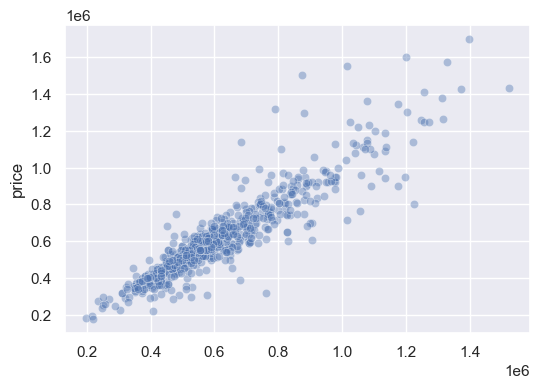

In [221]:
sn.scatterplot(x= pred_c, y= y_test, alpha = .4)

Text(0.5, 1.0, 'Feature Importance')

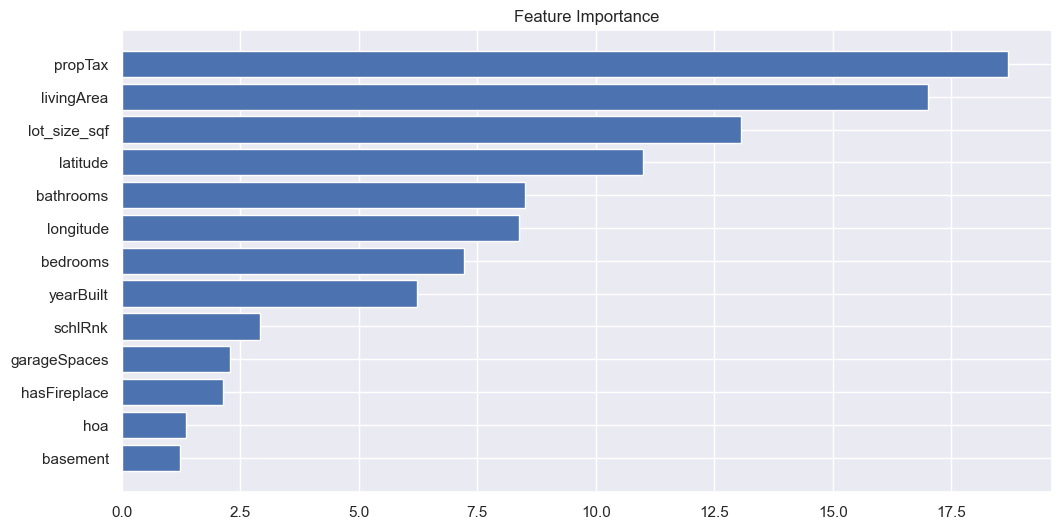

In [222]:
feature_importance = model_c.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [224]:
import shap

In [225]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model_c)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)

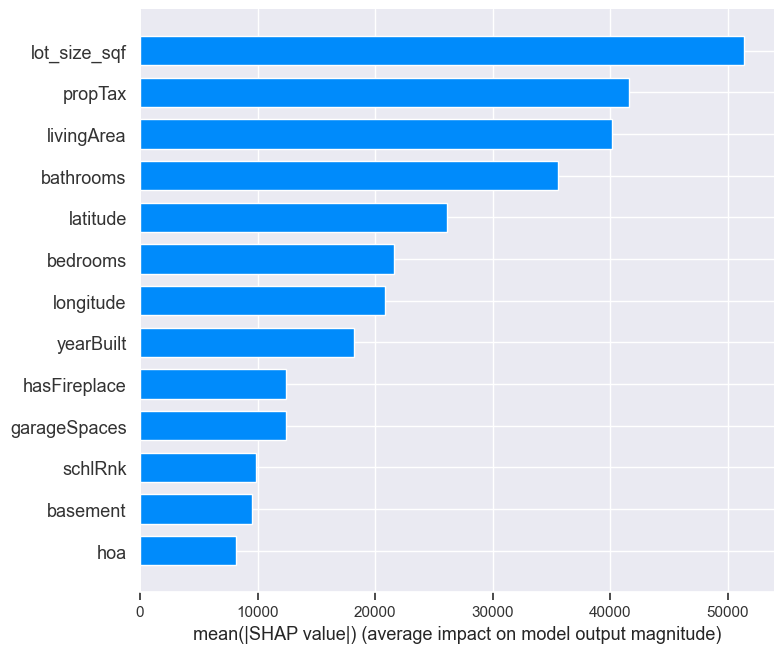

In [227]:
features = X.columns
shap.summary_plot(shap_values, X_train, feature_names=features, plot_type="bar")

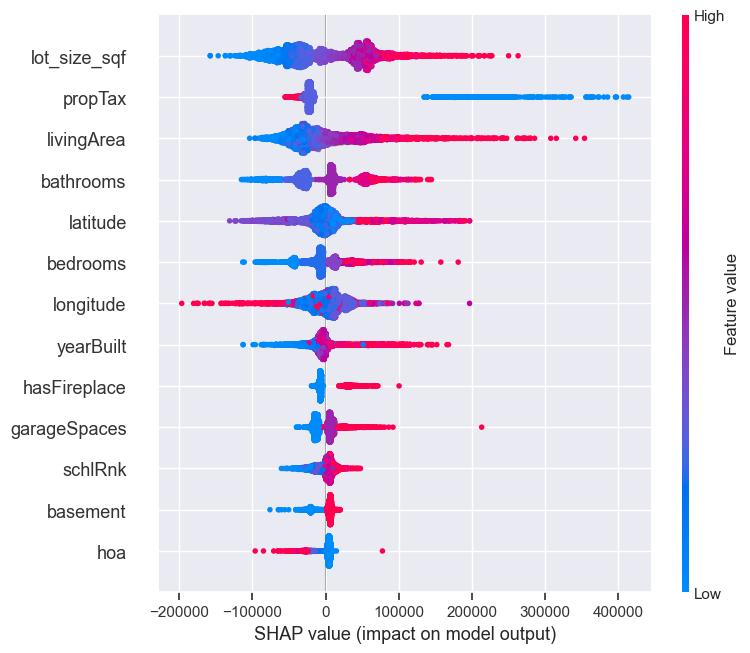

In [228]:
shap.summary_plot(shap_values, X_train, feature_names=features)

In [229]:
import pickle
  
filename = 'finalized_model.sav'
pickle.dump(model_c, open(filename, 'wb'))

In [230]:
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8374530701713051


# Ridge(L2) and Lasso(L1)

In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [173]:
df_cleaned.shape

(3572, 16)

In [172]:
df_nonan = df_cleaned.dropna()
df_nonan.shape

(3556, 16)

In [174]:
yn= df_nonan['price']
Xn= df_nonan.loc[:, df_nonan.columns != 'price']
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size = 0.2, random_state=5)

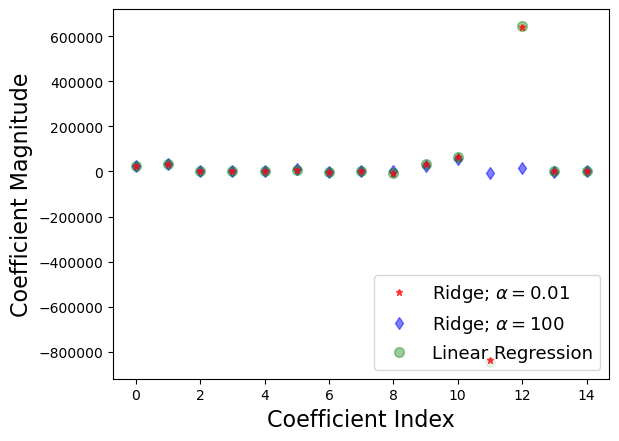

In [175]:
lr = LinearRegression()
lr.fit(Xn_train, yn_train)

rr = Ridge(alpha=0.01) 
# higher the alpha value, more restriction on the coefficients; low alpha > more generalization,
# in this case linear and ridge regression resembles
rr.fit(Xn_train, yn_train)

rr100 = Ridge(alpha=100) #  comparison with alpha value
rr100.fit(Xn_train, yn_train)

train_score=lr.score(Xn_train, yn_train)
test_score=lr.score(Xn_test, yn_test)

Ridge_train_score = rr.score(Xn_train,yn_train)
Ridge_test_score = rr.score(Xn_test, yn_test)
Ridge_train_score100 = rr100.score(Xn_train,yn_train)
Ridge_test_score100 = rr100.score(Xn_test, yn_test)
plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) 
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') 
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

In [176]:
print(Ridge_test_score, Ridge_test_score100 , test_score)

0.5918154926453896 0.5856832523367936 0.5916469278952698


In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(Xn_train,yn_train)
train_score=lasso.score(Xn_train,yn_train)
test_score=lasso.score(Xn_test,yn_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score) 
print("test score: ", test_score)
print("number of features used: ", coeff_used)

lasso001 = Lasso(alpha=0.01, max_iter=10e7)
lasso001.fit(Xn_train,yn_train)
train_score001=lasso001.score(Xn_train,yn_train)
test_score001=lasso001.score(Xn_test,yn_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print("training score for alpha=0.01:", train_score001) 
print("test score for alpha =0.01: ", test_score001)
print("number of features used: for alpha =0.01:", coeff_used001)
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(Xn_train,yn_train)
train_score00001=lasso00001.score(Xn_train,yn_train)
test_score00001=lasso00001.score(Xn_test,yn_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print("training score for alpha=0.0001:", train_score00001 )
print("test score for alpha =0.0001: ", test_score00001)
print("number of features used: for alpha =0.0001:", coeff_used00001)
lr = LinearRegression()
lr.fit(Xn_train,yn_train)
lr_train_score=lr.score(Xn_train,yn_train)
lr_test_score=lr.score(Xn_test,yn_test)
print("LR training score:", lr_train_score ) 
print("LR test score: ", lr_test_score)
plt.subplot(1,2,1)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.subplot(1,2,2)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.tight_layout()
plt.show()


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.039e+12, tolerance: 6.589e+09


training score: 0.6531162481416526
test score:  0.5917108312554676
number of features used:  12


# OLD models

In [129]:
?cb.CatBoostRegressor

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

model = cb.CatBoostRegressor(loss_function='RMSE')

model.fit(X_train, y_train, plot= True, eval_set=(X_test, y_test), verbose = False)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
cv_16_results = cross_val_score(model, X_train, y_train, cv=16, verbose= False)

In [178]:
cv_4_results

array([0.87800305, 0.82338977, 0.8016357 , 0.80776051, 0.82182361,
       0.89687614, 0.83757097, 0.86275506, 0.75684487,        nan,
       0.82699523, 0.71466365, 0.81357357, 0.77451968, 0.82687236,
       0.68805315])

In [ ]:
## build a model with limited price range (ie under 1M) to test

In [122]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 127512.69
R2: 0.76


<AxesSubplot:ylabel='price'>

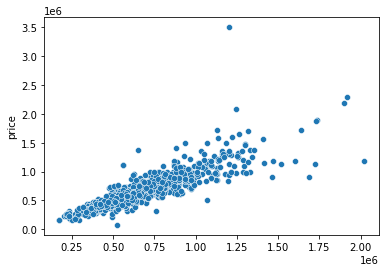

In [124]:
sn.scatterplot(x= pred, y= y_test)

In [125]:
max(y_test)

3500000.0

In [128]:
#number of the row
y_test[y_test == max(y_test)].index[0]

16694

In [131]:
X_test.loc[16694,:]

bathrooms        7.000000
bedrooms         6.000000
livingArea            NaN
hasView          0.000000
garageSpaces     2.000000
latitude        40.720566
longitude      -73.787529
age             87.000000
Name: 16694, dtype: float64

In [132]:
## Dropping NA and building model again
df.dropna(axis = 0 , inplace = True)
df.head()

<ipython-input-132-306deeb66d30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis = 0 , inplace = True)


bathrooms  bedrooms  livingArea  hasView  garageSpaces   latitude  \
142         5.0       4.0      3596.0        0             0  40.900173   
993         1.0       1.0       950.0        0             1  40.577118   
1436        3.0       4.0      2090.0        0             0  40.891418   
1459        4.0       5.0      2146.0        0             1  40.883373   
1481        2.0       4.0      2256.0        0             4  40.889427   

      longitude   age      price  
142  -73.910187  97.0  2075000.0  
993  -73.847794  62.0   310000.0  
1436 -73.831688  84.0   695000.0  
1459 -73.837082  27.0   749000.0  
1481 -73.816902  62.0   610000.0

In [133]:
df.shape

(6692, 9)

In [136]:
X2= df.iloc[:,:-1]
y2 = df['price']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state=5)

In [137]:
model2 = cb.CatBoostRegressor(loss_function='RMSE')

model2.fit(X_train2, y_train2, plot= True, eval_set=(X_test2, y_test2), verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [138]:
pred2 = model2.predict(X_test2)
rmse2 = (np.sqrt(mean_squared_error(y_test2, pred2)))
r22 = r2_score(y_test2, pred2)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse2))
print('R2: {:.2f}'.format(r22))

Testing performance
RMSE: 110254.91
R2: 0.82


<AxesSubplot:ylabel='price'>

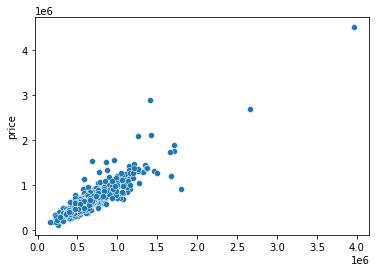

In [139]:
sn.scatterplot(x= pred2, y= y_test2)

## Evaluation Metrics for Regression
 * MAE:Mean Absolute Error
 * MSE : Mean Squared Error 
 * RMSE : Root Mean Squared error
 * R2 score: Coefficient of determination , Goodness of fit
 * Adjusted R2 score
        

# Random Forest 

In [140]:
from sklearn.ensemble import RandomForestRegressor

In [143]:
model3 = RandomForestRegressor(n_estimators= 500, random_state = 5)
model3.fit(X_train2, y_train2)
pred3= model3.predict(X_test2) 
rmse3 = (np.sqrt(mean_squared_error(y_test2, pred3)))
r23 = r2_score(y_test2, pred3)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse3))
print('R2: {:.2f}'.format(r23))

Testing performance
RMSE: 129588.76
R2: 0.75


In [ ]:
#use linear regression as next step: one time with l1 and l2 / one time without them

In [97]:
# Stuff

In [99]:
raw_data['resoFactsStats/structureType'].value_counts()

Colonial                   8375
Other                      3221
Townhouse                  1177
Contemporary                880
Ranch / Rambler             851
Cape Cod                    677
Modern                      498
Tudor                       383
Loft                        297
Split-level                 234
Queen Anne / Victorian      210
Bungalow                    202
Duplex                      146
cottage                      93
Apartment                    65
Garden                       52
Craftsman                    34
mansion                      30
Triplex                      23
Spanish                      18
High Rise                    16
Duplex - Up/Down             13
Georgian                     12
French                       10
Garden Apartment              4
Garage to Garage              3
Santa Fe / Pueblo Style       2
Penthouse                     2
Duplex - Side/Side            1
House                         1
conventional                  1
Detached

In [98]:
raw_data['resoFactsStats/roofType'].value_counts()

Other                               2691
Asphalt                             2365
Shake / Shingle                     2010
Flat                                 327
Slate                                151
Tile                                 131
Pitched                              100
Composition                           85
Shingle                               78
Built-up                              74
Flat,Rubber                           39
Asphalt/Tar                           33
Rubber                                29
Pitched,Shingle                       28
Asphalt/Tar,Flat                      25
Metal                                 16
Flat,Pitched                           5
Shingle,Other                          5
Flat,Shingle                           4
Flat,Other                             3
Flat,Metal                             3
Pitched,Other                          2
Asphalt/Tar,Pitched                    2
Asphalt/Tar,Flat,Rubber                1
Asphalt/Tar,Flat

In [33]:
raw_data['resoFactsStats/propertyCondition'].value_counts()

Existing,Excellent            5275
Existing,Good                 1106
Excellent                     1088
New Construction,Excellent     652
Good                           500
                              ... 
++ S Mint                        1
Brand new                        1
mint ++                          1
+++MINT+++                       1
Renovted                         1
Name: resoFactsStats/propertyCondition, Length: 244, dtype: int64

In [95]:
raw_data['resoFactsStats/lotSize'].value_counts()

2,500 sqft     3773
2,000 sqft     2349
4,000 sqft     2327
3,998 sqft     1429
0.06 Acres     1419
               ... 
3,726 sqft        1
11.47 Acres       1
5.22 Acres        1
8,775 sqft        1
5,105 sqft        1
Name: resoFactsStats/lotSize, Length: 5787, dtype: int64

In [93]:
raw_data['livingArea'].value_counts()

2000.0      1047
1200.0       839
1800.0       788
3000.0       669
1600.0       651
            ... 
4373.0         1
28080.0        1
155000.0       1
96152.0        1
54719.0        1
Name: livingArea, Length: 5337, dtype: int64

In [92]:
raw_data['resoFactsStats/livingArea'].value_counts()

2,000 sqft     1047
1,200 sqft      839
1,800 sqft      788
3,000 sqft      669
1,600 sqft      651
               ... 
4,723 sqft        1
4,686 sqft        1
13,568 sqft       1
3,895 sqft        1
5,603 sqft        1
Name: resoFactsStats/livingArea, Length: 5338, dtype: int64

In [38]:
raw_data['resoFactsStats/homeType'].value_counts(dropna= False)

Residential              13097
Residential Income        4382
Multiple Occupancy        1772
Condo                     1641
Single Family             1467
Land                       396
Townhouse                  295
Apartment                  163
Mixed Use                  138
Vacant Land                 68
Other                       10
Mobile / Manufactured        1
Name: resoFactsStats/homeType, dtype: int64

In [89]:
raw_data['resoFactsStats/hasView'].value_counts()

False    70604
True      5025
Name: resoFactsStats/hasView, dtype: int64

In [88]:
raw_data['resoFactsStats/hasGarage'].value_counts()

False    60634
True     14996
Name: resoFactsStats/hasGarage, dtype: int64

In [86]:
raw_data['resoFactsStats/garageSpaces'].value_counts()

0       60808
1        8710
2        4045
3         831
4         655
5         211
6         190
8          31
7          26
10         23
9          11
32         10
200         5
240         4
12          4
15          4
35          4
16          4
25          3
43          3
11          3
79          3
120         3
18          2
126         2
150         2
38          2
110         2
40          2
26          1
492         1
61          1
185         1
180         1
67          1
50          1
561         1
113         1
70          1
48          1
46          1
876         1
106         1
24          1
75          1
1422        1
166         1
33          1
400         1
29          1
19          1
20          1
212         1
276         1
28          1
190         1
Name: resoFactsStats/garageSpaces, dtype: int64

In [84]:
raw_data['resoFactsStats/frontageLength'].value_counts()

0.0                      9
25.0                     4
Road Frontage: 20 Ft     2
30.0                     2
75.0                     2
40175.0                  2
4375.0                   2
0                        1
Road Frontage: 109 Ft    1
Road Frontage: 25 Ft     1
101.0                    1
Road Frontage: 153       1
42.0                     1
40.0                     1
26.0                     1
Road Frontage: 172 Ft    1
Road Frontage: 32 Ft     1
Name: resoFactsStats/frontageLength, dtype: int64

In [83]:
raw_data['resoFactsStats/foundationDetails/0'].value_counts()

Concrete Perimeter    475
Block                 133
Other                 114
Slab                   49
Stone                  17
Concrete                5
Name: resoFactsStats/foundationDetails/0, dtype: int64

In [81]:
raw_data['resoFactsStats/flooring/0'].value_counts()
#combine in some boxes

Hardwood               12874
Tile                    3804
Carpet                   878
Other                    358
Laminate                 130
Wall To Wall Carpet      126
Ceramic Tile             103
Softwood                  53
Linoleum / Vinyl          40
Concrete                  28
Parquet                   18
Granite                   12
Linoleum                   9
None                       5
Marble                     2
Plywood                    1
Slate                      1
Name: resoFactsStats/flooring/0, dtype: int64

In [75]:
raw_data['resoFactsStats/fireplaces'].value_counts()

0.0    4934
1.0     631
2.0      85
3.0      14
4.0       6
5.0       4
6.0       2
9.0       1
Name: resoFactsStats/fireplaces, dtype: int64

In [102]:
raw_data['resoFactsStats/hasFireplace'].value_counts()

False    11640
True      7228
Name: resoFactsStats/hasFireplace, dtype: int64

In [176]:
raw_data['resoFactsStats/elementarySchoolDistrict'].value_counts()

Bronx 10                                 3042
Queens 26                                 992
Queens 27                                 904
Queens 24                                 729
Queens 29                                 707
Queens 25                                 657
Queens 28                                 649
Queens 30                                 543
UNKNOWN                                   541
Call Listing Agent                        399
City of New York                          179
Brooklyn 14                               123
Brooklyn 19                               119
Brooklyn 18                               106
Bronx 11                                   94
Bronx                                      87
Brooklyn 22                                78
Brooklyn 20                                59
Richmond 31                                44
Brooklyn 32                                43
Brooklyn 17                                42
Brooklyn 21                       

In [65]:
raw_data['resoFactsStats/basement'].value_counts()

Full                                            7363
Finished                                        6331
None                                            3455
Finished,Full                                   2807
Unfinished                                      1141
                                                ... 
Finished, Full, Walk-Out Access, See Remarks       1
Crawl Space,Full                                   1
Separate Entrance                                  1
Common,Finished,See Remarks                        1
Bilco Door(s),Full,Partial                         1
Name: resoFactsStats/basement, Length: 182, dtype: int64

In [58]:
raw_data['homeStatus'].value_counts()

SOLD               44912
RECENTLY_SOLD      17894
FOR_SALE           10945
PRE_FORECLOSURE     1702
FOR_RENT             151
FORECLOSED            23
PENDING                2
OTHER                  1
Name: homeStatus, dtype: int64

In [112]:
raw_data['homeStatus'].value_counts(normalize = True)

SOLD               0.593838
RECENTLY_SOLD      0.236599
FOR_SALE           0.144718
PRE_FORECLOSURE    0.022504
FOR_RENT           0.001997
FORECLOSED         0.000304
PENDING            0.000026
OTHER              0.000013
Name: homeStatus, dtype: float64

In [35]:
raw_data['latitude'].value_counts()

40.711506    10
40.888504     9
40.723167     9
40.713036     8
40.817902     7
             ..
40.675186     1
40.675171     1
40.674740     1
40.679279     1
40.712433     1
Name: latitude, Length: 17470, dtype: int64

In [118]:
def detect_outlier(data_1):
    
    outliers=[]
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [51]:
df.columns

Index(['address/city', 'address/community', 'address/neighborhood',
       'address/state', 'address/streetAddress', 'address/subdivision',
       'address/zipcode', 'bathrooms', 'bedrooms', 'currency',
       ...
       'schools/2/rating', 'schools/2/size', 'schools/2/studentsPerTeacher',
       'schools/2/totalCount', 'schools/2/type', 'url', 'yearBuilt', 'zpid',
       'new_date_onMAr', 'y-m'],
      dtype='object', length=1509)

In [ ]:
for i in df.columns()

<AxesSubplot:xlabel='address/zipcode', ylabel='price'>

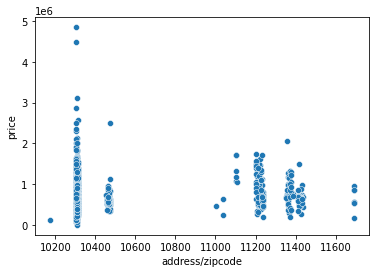

In [44]:
sn.scatterplot(x= 'address/zipcode',
                    y="price",
                    data= df)

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

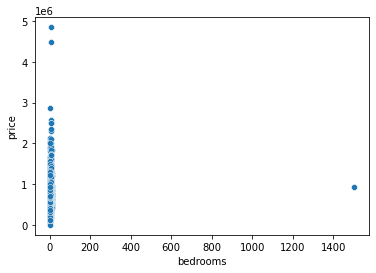

In [45]:
sn.scatterplot(x= 'bedrooms',
                    y="price",
                    data= df)

In [46]:
df.bedrooms.describe()

count    6083.000000
mean        3.916982
std        19.273073
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max      1502.000000
Name: bedrooms, dtype: float64

In [49]:
bedroom_out = detect_outlier(df['bedrooms'])
bedroom_out

[1502.0]

In [119]:
price_out = detect_outlier(raw_data['price'])
price_out

[8500000.0,
 8000000.0,
 10995000.0,
 11500000.0,
 8750000.0,
 8485000.0,
 24000000.0,
 22800000.0,
 22000000.0,
 7975000.0,
 18500000.0,
 15000000.0,
 10750000.0,
 32500000.0,
 22000000.0,
 21800000.0,
 19750000.0,
 65000000.0,
 8995000.0,
 26900000.0,
 15995000.0,
 8000000.0,
 15000000.0,
 8900000.0,
 7995000.0,
 36000000.0,
 9975000.0,
 12750000.0,
 12988000.0,
 8850000.0,
 8995000.0,
 11999000.0,
 9950000.0,
 29000000.0,
 14600000.0,
 15950000.0,
 9500000.0,
 10399000.0,
 11900000.0,
 11700000.0,
 41000000.0,
 35000000.0,
 17250000.0,
 10950000.0,
 11950000.0,
 13750000.0,
 9000000.0,
 24000000.0,
 11500000.0,
 8750000.0,
 29950000.0,
 11950000.0,
 14900000.0,
 9880000.0,
 12000000.0,
 12750000.0,
 9900000.0,
 13875000.0,
 10500000.0,
 11500000.0,
 10900000.0,
 20750000.0,
 17500000.0,
 9500000.0,
 8000000.0,
 8450000.0,
 8450000.0,
 9950000.0,
 12750000.0,
 12000000.0,
 13995000.0,
 23750000.0,
 9200000.0,
 9999000.0,
 17500000.0,
 12500000.0,
 9995000.0,
 9950000.0,
 16500000.0,


In [121]:
df.describe()

address/zipcode    bathrooms     bedrooms    yearBuilt    livingArea  \
count      6082.000000  6081.000000  6082.000000  6075.000000   5995.000000   
mean      10340.896251     2.918599     3.670668  1971.231276   1813.499583   
std         174.923191     1.230553     1.546588    31.572934    819.689685   
min       10172.000000     1.000000     1.000000  1859.000000     25.000000   
25%       10306.000000     2.000000     3.000000  1951.000000   1275.000000   
50%       10308.000000     3.000000     3.000000  1975.000000   1600.000000   
75%       10312.000000     4.000000     4.000000  1996.000000   2180.000000   
max       11693.000000    12.000000    14.000000  2020.000000  17175.000000   

       resoFactsStats/hasView  resoFactsStats/hasGarage  \
count             6082.000000               6082.000000   
mean                 0.036501                  0.543078   
std                  0.187549                  0.498182   
min                  0.000000                  0.000000   
25%                  0.000000                  0.000000   
50%                  0.000000                  1.000000   
75%                  0.000000                  1.000000   
max                  1.000000                  1.000000   

       resoFactsStats/garageSpaces     latitude    longitude         price  \
count                  6082.000000  6082.000000  6082.000000  6.082000e+03   
mean                      1.026143    40.585276   -74.135694  6.301233e+05   
std                      19.344712     0.048501     0.072392  2.420029e+05   
min                       0.000000    40.498634   -74.253433  1.000000e+01   
25%                       0.000000    40.555036   -74.183777  4.750000e+05   
50%                       1.000000    40.582848   -74.140694  5.900000e+05   
75%                       1.000000    40.613318   -74.104919  7.290000e+05   
max                    1422.000000    40.908253   -73.702202  4.850000e+06   

               age  
count  6075.000000  
mean     50.768724  
std      31.572934  
min       2.000000  
25%      26.000000  
50%      47.000000  
75%      71.000000  
max     163.000000

In [21]:
#raw_data

In [18]:
raw_data.describe()

address/community  address/zipcode     bathrooms      bedrooms  \
count                0.0     75611.000000  56577.000000  56166.000000   
mean                 NaN     10885.170068      2.743733      3.983851   
std                  NaN       620.829405      5.910817      6.775822   
min                  NaN       148.000000      0.500000      1.000000   
25%                  NaN     10314.000000      2.000000      3.000000   
50%                  NaN     11204.000000      2.000000      3.000000   
75%                  NaN     11367.000000      3.000000      5.000000   
max                  NaN     85128.000000   1346.000000   1502.000000   

         dateposted      latitude     livingArea     longitude         price  \
count  2.343000e+04  75604.000000   66419.000000  75604.000000  7.559100e+04   
mean   1.604629e+12     40.699879    3515.221533    -73.928784  1.064926e+06   
std    9.375642e+09      0.100186   19275.605159      0.133133  2.717389e+06   
min    1.451194e+12     40.498634       1.000000    -74.255333  1.000000e+00   
25%    1.600183e+12     40.614593    1312.000000    -73.997108  4.770000e+05   
50%    1.606166e+12     40.696003    1848.000000    -73.906219  6.776710e+05   
75%    1.610520e+12     40.763708    2600.000000    -73.832458  9.650000e+05   
max    1.611281e+12     40.912682  986641.000000    -73.700432  1.000000e+08   

       priceHistory  ...  schools/1/studentsPerTeacher  schools/1/totalCount  \
count           0.0  ...                  72815.000000          74719.000000   
mean            NaN  ...                     14.312230              1.275941   
std             NaN  ...                      2.423886              0.852413   
min             NaN  ...                      7.000000              1.000000   
25%             NaN  ...                     13.000000              1.000000   
50%             NaN  ...                     14.000000              1.000000   
75%             NaN  ...                     16.000000              1.000000   
max             NaN  ...                     24.000000             13.000000   

       schools/2/assigned  schools/2/distance  schools/2/rating  \
count                 0.0        55543.000000      55506.000000   
mean                  NaN            1.166651          3.702032   
std                   NaN            1.244332          1.756765   
min                   NaN            0.000000          1.000000   
25%                   NaN            0.500000          3.000000   
50%                   NaN            0.900000          3.000000   
75%                   NaN            1.600000          4.000000   
max                   NaN          208.700000         10.000000   

       schools/2/size  schools/2/studentsPerTeacher  schools/2/totalCount  \
count    55482.000000                  54985.000000          55543.000000   
mean      2008.657132                     17.143894              1.205732   
std       1331.165212                      2.768755              0.617115   
min        101.000000                      7.000000              1.000000   
25%        526.000000                     15.000000              1.000000   
50%       1946.000000                     18.000000              1.000000   
75%       3281.000000                     19.000000              1.000000   
max       5839.000000                     24.000000              5.000000   

          yearBuilt          zpid  
count  69898.000000  7.562900e+04  
mean    1947.429955  3.165939e+08  
std       38.606827  6.823292e+08  
min        1.000000  2.977666e+07  
25%     1920.000000  3.073761e+07  
50%     1940.000000  3.220877e+07  
75%     1970.000000  7.973850e+07  
max     4073.000000  2.146981e+09  

[8 rows x 442 columns]

In [110]:
df2 = raw_data.sort_values('price')

In [111]:
df2['price']

60967    1.0
9064     1.0
60952    1.0
62088    1.0
74700    1.0
        ... 
49646    NaN
54605    NaN
57269    NaN
63157    NaN
65687    NaN
Name: price, Length: 75630, dtype: float64

In [22]:
new_df = raw_data.dropna(subset= ['price'])

In [107]:
new_df = raw_data[raw_data['price']>= 50000]
new_df = raw_data[raw_data['homeStatus']== 'SOLD' | raw_data['homeStatus'] =='RECENTLY_SOLD']

In [108]:
label = new_df['price']

In [53]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df2['price'])

60967            1.0
9064             1.0
60952            1.0
62088            1.0
74700            1.0
62070            1.0
62053            1.0
27833            1.0
40712            1.0
57771            1.0
62000            1.0
5268             1.0
29081            1.0
15373            1.0
4067             1.0
61855            1.0
33714            1.0
38379            1.0
33715            1.0
33722            1.0
949              1.0
40340            1.0
69871            1.0
4150             1.0
38635            1.0
38634            1.0
47438            1.0
47437            1.0
47436            1.0
69970            1.0
61213            1.0
60904            1.0
59999            1.0
17705            1.0
57831            1.0
33719            1.0
11796            1.0
63557            1.0
38350            1.0
70462            1.0
44389            1.0
63787            1.0
44397            1.0
41230            1.0
35770            1.0
66345            1.0
41316            1.0
3944         

<AxesSubplot:xlabel='price'>

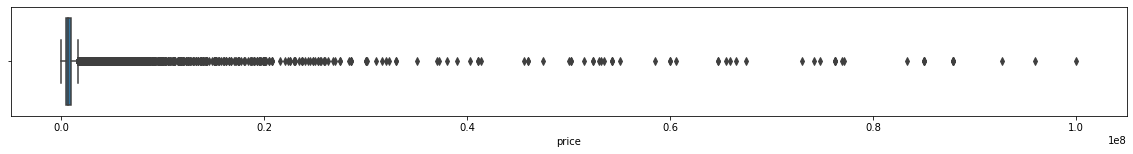

In [109]:
fig, ax =plt.subplots(figsize=(20,2))
sn.boxplot(x =label)

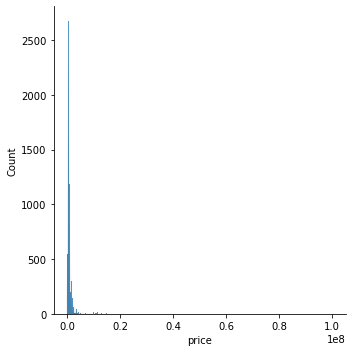

In [35]:
sn.displot(label)

In [29]:
min(label) , max(label)

(1.0, 100000000.0)

In [41]:
new_df.sort_values(by=['price'], ascending=False)['price']

60967            1.0
9064             1.0
60952            1.0
62088            1.0
74700            1.0
            ...     
10791     87920384.0
68908     90000000.0
22412     92725017.0
41870     96000000.0
24554    100000000.0
Name: price, Length: 75591, dtype: float64

<AxesSubplot:>

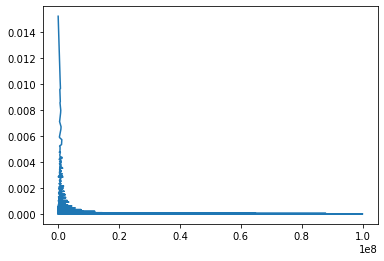

In [44]:
label.value_counts(normalize = True).sort_values().plot()

In [ ]:
# 10 dollars doesn't look right , taking it out

In [46]:
new_df.shape

(75591, 1507)

In [24]:
new_df['age'] = 2022 - new_df['yearBuilt']

<ipython-input-24-d0c8aed4ac03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['age'] = 2022 - new_df['yearBuilt']


In [25]:
columns = ['bathrooms', 'bedrooms', 'latitude', 'longitude','age', 'livingArea', 'resoFactsStats/homeType' ]

In [26]:
df= new_df[columns]
df.head()
#df.info

bathrooms  bedrooms   latitude  longitude    age  livingArea
0        2.0       5.0  40.877743 -73.910866  102.0      1889.0
1        8.0       8.0  40.892689 -73.910667   82.0      7000.0
2        3.0       4.0  40.883419 -73.918106  102.0      4233.0
3        6.0       5.0  40.885033 -73.917793   72.0      7000.0
4        6.0       5.0  40.881702 -73.914185    2.0         NaN

# Scaling 

In [55]:
y = label
X = df

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [57]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [58]:
model.fit(X_train, y_train)


Learning rate set to 0.078283
0:	learn: 2711978.3497738	total: 145ms	remaining: 2m 24s
1:	learn: 2677499.1292687	total: 153ms	remaining: 1m 16s
2:	learn: 2648341.8485350	total: 160ms	remaining: 53.2s
3:	learn: 2618092.6004805	total: 168ms	remaining: 41.8s
4:	learn: 2594147.4540297	total: 180ms	remaining: 35.9s
5:	learn: 2573340.4127471	total: 190ms	remaining: 31.5s
6:	learn: 2552947.7732536	total: 197ms	remaining: 27.9s
7:	learn: 2533379.3094256	total: 207ms	remaining: 25.7s
8:	learn: 2518235.5044598	total: 217ms	remaining: 23.9s
9:	learn: 2504494.5760335	total: 230ms	remaining: 22.8s
10:	learn: 2490620.6898056	total: 239ms	remaining: 21.5s
11:	learn: 2478555.5519220	total: 245ms	remaining: 20.2s
12:	learn: 2467101.3683330	total: 252ms	remaining: 19.1s
13:	learn: 2454270.4720465	total: 261ms	remaining: 18.4s
14:	learn: 2439597.9472087	total: 275ms	remaining: 18s
15:	learn: 2428016.4993015	total: 283ms	remaining: 17.4s
16:	learn: 2420890.0864051	total: 288ms	remaining: 16.7s
17:	learn: 

157:	learn: 2055833.1257847	total: 1.39s	remaining: 7.4s
158:	learn: 2054906.1147693	total: 1.4s	remaining: 7.38s
159:	learn: 2054185.0847252	total: 1.41s	remaining: 7.38s
160:	learn: 2053199.5756369	total: 1.41s	remaining: 7.36s
161:	learn: 2047706.3532979	total: 1.42s	remaining: 7.33s
162:	learn: 2046924.1445726	total: 1.42s	remaining: 7.31s
163:	learn: 2045537.1009808	total: 1.43s	remaining: 7.3s
164:	learn: 2044539.3450251	total: 1.45s	remaining: 7.32s
165:	learn: 2042909.4360870	total: 1.45s	remaining: 7.31s
166:	learn: 2042021.2467773	total: 1.46s	remaining: 7.29s
167:	learn: 2041113.0869142	total: 1.47s	remaining: 7.28s
168:	learn: 2040085.6228316	total: 1.48s	remaining: 7.27s
169:	learn: 2039662.0778922	total: 1.49s	remaining: 7.27s
170:	learn: 2039019.9403924	total: 1.5s	remaining: 7.25s
171:	learn: 2037945.0485683	total: 1.5s	remaining: 7.24s
172:	learn: 2036106.1902496	total: 1.51s	remaining: 7.23s
173:	learn: 2035764.5100621	total: 1.52s	remaining: 7.23s
174:	learn: 2035066

310:	learn: 1885756.9389148	total: 2.61s	remaining: 5.79s
311:	learn: 1885368.3702913	total: 2.62s	remaining: 5.78s
312:	learn: 1884897.9757559	total: 2.63s	remaining: 5.77s
313:	learn: 1884601.7705167	total: 2.63s	remaining: 5.76s
314:	learn: 1883701.8699134	total: 2.65s	remaining: 5.75s
315:	learn: 1882729.0839343	total: 2.66s	remaining: 5.76s
316:	learn: 1880474.4018639	total: 2.67s	remaining: 5.75s
317:	learn: 1879798.7318130	total: 2.68s	remaining: 5.75s
318:	learn: 1879746.2736682	total: 2.69s	remaining: 5.74s
319:	learn: 1877706.7149359	total: 2.7s	remaining: 5.73s
320:	learn: 1877496.6752958	total: 2.7s	remaining: 5.71s
321:	learn: 1877387.0038402	total: 2.71s	remaining: 5.71s
322:	learn: 1876533.9837170	total: 2.72s	remaining: 5.7s
323:	learn: 1875444.5888066	total: 2.73s	remaining: 5.7s
324:	learn: 1873594.6967710	total: 2.74s	remaining: 5.69s
325:	learn: 1873196.3199953	total: 2.75s	remaining: 5.69s
326:	learn: 1871478.9363398	total: 2.76s	remaining: 5.68s
327:	learn: 187050

461:	learn: 1759993.8135589	total: 4.03s	remaining: 4.7s
462:	learn: 1758732.4141146	total: 4.04s	remaining: 4.69s
463:	learn: 1754808.7390502	total: 4.05s	remaining: 4.68s
464:	learn: 1753917.9370421	total: 4.06s	remaining: 4.67s
465:	learn: 1753639.0827635	total: 4.07s	remaining: 4.66s
466:	learn: 1753544.5744111	total: 4.08s	remaining: 4.66s
467:	learn: 1752523.6496850	total: 4.09s	remaining: 4.65s
468:	learn: 1748936.3256251	total: 4.1s	remaining: 4.64s
469:	learn: 1748721.3942116	total: 4.1s	remaining: 4.63s
470:	learn: 1747018.3651912	total: 4.11s	remaining: 4.62s
471:	learn: 1746906.5301004	total: 4.12s	remaining: 4.61s
472:	learn: 1745962.0052856	total: 4.13s	remaining: 4.6s
473:	learn: 1745753.8838193	total: 4.14s	remaining: 4.59s
474:	learn: 1744159.5388563	total: 4.14s	remaining: 4.58s
475:	learn: 1743149.2874169	total: 4.15s	remaining: 4.57s
476:	learn: 1742163.7568097	total: 4.16s	remaining: 4.56s
477:	learn: 1742149.3949133	total: 4.16s	remaining: 4.54s
478:	learn: 174121

623:	learn: 1637066.9691891	total: 5.43s	remaining: 3.27s
624:	learn: 1636996.1753530	total: 5.44s	remaining: 3.27s
625:	learn: 1636277.9734299	total: 5.45s	remaining: 3.26s
626:	learn: 1635324.6801674	total: 5.46s	remaining: 3.25s
627:	learn: 1634552.3828058	total: 5.47s	remaining: 3.24s
628:	learn: 1634359.8635792	total: 5.47s	remaining: 3.23s
629:	learn: 1634236.8157153	total: 5.49s	remaining: 3.22s
630:	learn: 1634227.8107632	total: 5.5s	remaining: 3.21s
631:	learn: 1632996.8987405	total: 5.51s	remaining: 3.21s
632:	learn: 1632990.2353748	total: 5.52s	remaining: 3.2s
633:	learn: 1632008.1367216	total: 5.53s	remaining: 3.19s
634:	learn: 1631710.2565785	total: 5.54s	remaining: 3.18s
635:	learn: 1630906.9323605	total: 5.55s	remaining: 3.17s
636:	learn: 1628841.6343772	total: 5.56s	remaining: 3.17s
637:	learn: 1627911.0377519	total: 5.57s	remaining: 3.16s
638:	learn: 1627577.4108991	total: 5.58s	remaining: 3.15s
639:	learn: 1627570.9175070	total: 5.59s	remaining: 3.14s
640:	learn: 1626

773:	learn: 1559898.4966885	total: 7.01s	remaining: 2.05s
774:	learn: 1557627.3799401	total: 7.02s	remaining: 2.04s
775:	learn: 1557261.7177483	total: 7.03s	remaining: 2.03s
776:	learn: 1557198.9758502	total: 7.04s	remaining: 2.02s
777:	learn: 1557175.5019969	total: 7.04s	remaining: 2.01s
778:	learn: 1557100.4926721	total: 7.05s	remaining: 2s
779:	learn: 1555719.4089112	total: 7.05s	remaining: 1.99s
780:	learn: 1555550.8224912	total: 7.06s	remaining: 1.98s
781:	learn: 1555096.4031123	total: 7.07s	remaining: 1.97s
782:	learn: 1554301.3433985	total: 7.07s	remaining: 1.96s
783:	learn: 1553837.2423179	total: 7.08s	remaining: 1.95s
784:	learn: 1553598.4233321	total: 7.1s	remaining: 1.94s
785:	learn: 1551449.4590094	total: 7.1s	remaining: 1.93s
786:	learn: 1550276.1691882	total: 7.11s	remaining: 1.92s
787:	learn: 1550263.7092517	total: 7.11s	remaining: 1.91s
788:	learn: 1549959.3248653	total: 7.12s	remaining: 1.9s
789:	learn: 1549746.1008306	total: 7.13s	remaining: 1.89s
790:	learn: 1549318.

917:	learn: 1487683.5960728	total: 8.24s	remaining: 737ms
918:	learn: 1487477.2282088	total: 8.25s	remaining: 728ms
919:	learn: 1487167.0943142	total: 8.26s	remaining: 718ms
920:	learn: 1486841.9853954	total: 8.27s	remaining: 709ms
921:	learn: 1486227.6331538	total: 8.28s	remaining: 700ms
922:	learn: 1485893.7119555	total: 8.29s	remaining: 691ms
923:	learn: 1485394.9025146	total: 8.3s	remaining: 682ms
924:	learn: 1485199.0096356	total: 8.31s	remaining: 674ms
925:	learn: 1485054.5788500	total: 8.32s	remaining: 665ms
926:	learn: 1484374.7409710	total: 8.33s	remaining: 656ms
927:	learn: 1484003.0566140	total: 8.34s	remaining: 647ms
928:	learn: 1483675.3993658	total: 8.35s	remaining: 638ms
929:	learn: 1483487.5786522	total: 8.35s	remaining: 629ms
930:	learn: 1483365.8646061	total: 8.36s	remaining: 620ms
931:	learn: 1482939.4484851	total: 8.37s	remaining: 611ms
932:	learn: 1482779.3102385	total: 8.38s	remaining: 602ms
933:	learn: 1482375.7610922	total: 8.38s	remaining: 592ms
934:	learn: 148

In [68]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
#print('R2: {:.2f}’.format(r2)')

Testing performance
RMSE: 1949826.99


C:\Users\Owner\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='price'>

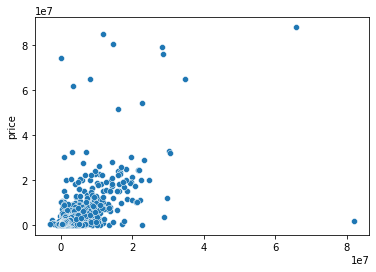

In [69]:
sn.scatterplot(pred, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='price'>

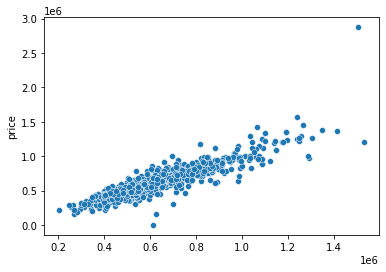

In [74]:
sn.scatterplot(pred, y_test)

C:\Users\Owner\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price'>

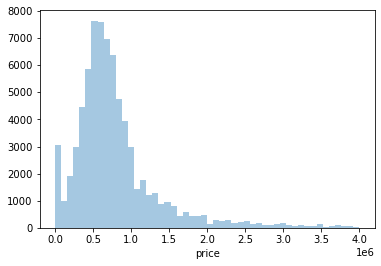

In [50]:
label = new_df['price']

sn.distplot(raw_data.loc[raw_data['price']<4000000, 'price'], kde= False)

In [10]:
label.describe()

count    7.559100e+04
mean     1.064926e+06
std      2.717389e+06
min      1.000000e+00
25%      4.770000e+05
50%      6.776710e+05
75%      9.650000e+05
max      1.000000e+08
Name: price, dtype: float64

In [12]:
label.shape

(75630,)

In [19]:
label.isna().value_counts()

False    75591
True        39
Name: price, dtype: int64